# CW + Diversity Regularization on CIFAR10

In [20]:
import torch
import torch.nn as nn
from torch.utils.data.sampler import SubsetRandomSampler

import torchvision
import torchvision.transforms as transforms
import torch.optim as optim

import pickle
import datetime
import glob
import os
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('precision', 10)

# custom code imports
from models import *
from neuron_coverage import *
from cw_div import *

import matplotlib.pyplot as plt
%matplotlib inline

%load_ext autoreload
%autoreload 2

device = torch.device("cpu")
if torch.cuda.is_available():
    print('CUDA is available!')
    device = torch.device("cuda")
else:
    print('CUDA is not available...')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
CUDA is available!


# Load Data

In [3]:
data_dir = 'C:\data\MNIST'

if not os.path.exists(data_dir):
    os.makedirs(data_dir)

batch_size = 100 # determines how many of each class we want

def get_same_index(targets, label):
    '''
    Returns indices corresponding to the target label
    which the dataloader uses to serve downstream.
    '''
    label_indices = []
    for i in range(len(targets)):
        if targets[i] == label:
            label_indices.append(i)
    return label_indices

classes = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

dataset = torchvision.datasets.MNIST(root=data_dir, 
                                     train=False, 
                                     download=True,
                                     transform=transforms.Compose([
                                         transforms.ToTensor()
                                     ]))

test_loader = torch.utils.data.DataLoader(dataset,
                                          batch_size=batch_size, 
                                          shuffle=False,
                                          pin_memory=True)

In [1]:
# def generate_batch(dataset, num_per_class):
#     '''
#     creates a batch of inputs with a customizable number of instances for each class
#     dataset       : torchvision.dataset
#     num_per_class : iterable containing the desired counts of each class
#                     example: torch.ones(num_classes) * 100
#     '''
    
#     def get_same_index(targets, label):
#         '''
#         Returns indices corresponding to the target label
#         which the dataloader uses to serve downstream.
#         '''
#         label_indices = []
#         for i in range(len(targets)):
#             if targets[i] == label:
#                 label_indices.append(i)
#         return label_indices

#     data = []
#     labels = []
    
#     num_classes = len(dataset.targets.unique())
    
#     for i in range(num_classes):
        
#         target_indices = get_same_index(dataset.targets, i)
#         class_batch_size = int(num_per_class[i])
        
#         data_loader = torch.utils.data.DataLoader(dataset,
#             batch_size=class_batch_size, 
#             sampler=SubsetRandomSampler(target_indices),
#             shuffle=False,
#             pin_memory=True)

#         inputs, targets = next(iter(data_loader))

#         data.append(inputs)
#         labels.append(targets)

#     inputs = torch.stack(data).to(device).view(-1,1,28,28)
#     targets = torch.stack(labels).to(device).view(-1)
    
#     return inputs, targets

In [8]:
# num_per_class = torch.ones(len(dataset.targets.unique())) * 100
# inputs, targets = generate_batch(dataset, num_per_class)

## Generate per class batches for NC evaluation

In [156]:
data = []
labels = []

for i in range(len(classes)):
    
    target_indices = get_same_index(dataset.targets, i)
    
    test_loader = torch.utils.data.DataLoader(dataset,
        batch_size=batch_size, 
        sampler=torch.utils.data.sampler.SubsetRandomSampler(target_indices),
        shuffle=False,
        num_workers=2, 
        pin_memory=True)
    
    inputs, targets = next(iter(test_loader))
    
    data.append(inputs)
    labels.append(targets)
    
inputs = torch.stack(data).to(device).view(-1,1,28,28)
targets = torch.stack(labels).to(device).view(-1)

In [18]:
# # confirm that all the images are still intact after reshaping the tensor view
# orig_inputs = all_inputs.clone().cpu().detach().numpy()
# for img in orig_inputs:
#     plt.imshow(np.transpose(np.squeeze(img), (1, 2, 0))) 
#     plt.show()

# Train or Load Pretrained Model if available

In [9]:
n_epochs = 10
batch_size_train = 64
batch_size_test = 100
learning_rate = 0.01
momentum = 0.5

random_seed = 1
torch.manual_seed(random_seed)

In [10]:
retrain = False
track_low_high = False

model = ConvNet().to(device)
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)

# check to see if we can just load a previous model
# %mkdir models
latest_model = None
m_type = model.__class__.__name__
prev_models = glob.glob('pretrained_models/mnist/*'+ m_type +'*.pth')
if prev_models:
    latest_model = max(prev_models, key=os.path.getctime)

if (retrain is False 
    and latest_model is not None 
    and m_type in latest_model):  
    print('loading model', latest_model)
    model.load_state_dict(torch.load(latest_model))  
else:
    if track_low_high:
        model.init_dict(model.lowhigh_dict, inputs, 'relu', {'low': 0, 'high': 0})
        try:
            for epoch in range(1, n_epochs + 1):
                model.hook_lowhigh_dict('relu')
                train(model, device, train_loader, optimizer, epoch)
                model.remove_hooks()
                test(model, device, test_loader)    
        finally:
            model.remove_hooks()   
    else:
        for epoch in range(1, n_epochs + 1):
            train(model, device, train_loader, optimizer, epoch)
            acc = test(model, device, test_loader)  
    torch.save(model.state_dict(), 'pretrained_models/mnist/model_' + m_type + '_' + str(datetime.datetime.now()).replace(':','.') + '_' + str(acc) + '.pth')

loading model pretrained_models/mnist\model_ConvNet_2019-07-25 16.16.26.580052_98.82.pth


## Evaluate per class and overall accuracy

In [78]:
def get_acc(model, device, test_loader, sampler=False, class_idx=None, classes=None):
    # model.eval()
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            
    if sampler:
        if class_idx is None:
            raise Exception('you must provide an integer class index if sampler=True')
        if classes is None:
            raise Exception('you must provide an iterable of class indices if sampler=True')
        values, counts = np.unique(test_loader.dataset.targets, return_counts=True) 
        divisor = counts[class_idx]
        acc = 100. * correct / divisor
        print(classes[class_idx] + '\t accuracy: {}/{} ({:.2f}%)'.format(correct, divisor, acc))
    else:
        divisor = len(test_loader.dataset)
        acc = 100. * correct / divisor
        print('accuracy: {}/{} ({:.2f}%)'.format(correct, divisor, acc))

In [81]:
# evaluate on total test set
get_acc(model, device, test_loader)

accuracy: 9882/10000 (98.82%)


In [60]:
# evaluate on each class separately534+
for i in range(len(classes)):
    
    target_indices = get_same_index(dataset.targets, i)
    
    test_loader = torch.utils.data.DataLoader(dataset,
        batch_size=batch_size, 
        sampler=SubsetRandomSampler(target_indices),
        shuffle=False,
        pin_memory=True)
    
    get_acc(model, device, test_loader, sampler=True, class_idx=i, classes=classes)

0	 accuracy: 976/980 (99.59%)
1	 accuracy: 1131/1135 (99.65%)
2	 accuracy: 1021/1032 (98.93%)
3	 accuracy: 994/1010 (98.42%)
4	 accuracy: 980/982 (99.80%)
5	 accuracy: 882/892 (98.88%)
6	 accuracy: 950/958 (99.16%)
7	 accuracy: 1004/1028 (97.67%)
8	 accuracy: 961/974 (98.67%)
9	 accuracy: 983/1009 (97.42%)


# Evaluating Neuron Coverage Per Class

In [24]:
nc_thresholds = np.arange(0,1,0.1)

neuron_coverages_by_class = {}

for i in range(len(classes)):
    
    threshold_results = {}
    
    for t in nc_thresholds:
        
        t = round(t,2)

        covered_neurons, total_neurons, neuron_coverage = eval_nc(model, inputs[i], t)
        print(classes[i] + ' neuron_coverage_' + str(t), neuron_coverage)

        threshold_results[str(t)] = neuron_coverage
    
    neuron_coverages_by_class[classes[i]] = threshold_results


0 neuron_coverage_0.0 0.8260755336617406



0 neuron_coverage_0.1 0.26157635467980295



0 neuron_coverage_0.2 0.14870279146141216



0 neuron_coverage_0.3 0.09507389162561576



0 neuron_coverage_0.4 0.06505747126436781



0 neuron_coverage_0.5 0.043645320197044334



0 neuron_coverage_0.6 0.026502463054187193



0 neuron_coverage_0.7 0.011264367816091954



0 neuron_coverage_0.8 0.002988505747126437



0 neuron_coverage_0.9 0.0012151067323481117



1 neuron_coverage_0.0 0.7785878489326765



1 neuron_coverage_0.1 0.15261083743842366



1 neuron_coverage_0.2 0.07678160919540229



1 neuron_coverage_0.3 0.044696223316912975



1 neuron_coverage_0.4 0.03070607553366174



1 neuron_coverage_0.5 0.021510673234811165



1 neuron_coverage_0.6 0.015008210180623973



1 neuron_coverage_0.7 0.00916256157635468



1 neuron_coverage_0.8 0.004499178981937603



1 neuron_coverage_0.9 0.001477832512315271



2 neuron_coverage_0.0 0.8783251231527094



2 neuron_coverage_0.1 0.29628899835796385



2 neuron_coverage_0.2 0.1631527093596059



2 neuron_coverage_0.3 0.09536945812807882



2 neuron_coverage_0.4 0.05921182266009852



2 neuron_coverage_0.5 0.03760262725779967



2 neuron_coverage_0.6 0.020853858784893268



2 neuron_coverage_0.7 0.009753694581280788



2 neuron_coverage_0.8 0.003645320197044335



2 neuron_coverage_0.9 0.001477832512315271



3 neuron_coverage_0.0 0.8488669950738916



3 neuron_coverage_0.1 0.2514614121510673



3 neuron_coverage_0.2 0.1335960591133005



3 neuron_coverage_0.3 0.07885057471264367



3 neuron_coverage_0.4 0.051527093596059115



3 neuron_coverage_0.5 0.032742200328407224



3 neuron_coverage_0.6 0.02006568144499179



3 neuron_coverage_0.7 0.00889983579638752



3 neuron_coverage_0.8 0.003513957307060755



3 neuron_coverage_0.9 0.0012151067323481117



4 neuron_coverage_0.0 0.8455500821018063



4 neuron_coverage_0.1 0.24292282430213466



4 neuron_coverage_0.2 0.13885057471264367



4 neuron_coverage_0.3 0.08660098522167488



4 neuron_coverage_0.4 0.05376026272577997



4 neuron_coverage_0.5 0.03201970443349754



4 neuron_coverage_0.6 0.01658456486042693



4 neuron_coverage_0.7 0.007783251231527093



4 neuron_coverage_0.8 0.0027914614121510675



4 neuron_coverage_0.9 0.001083743842364532



5 neuron_coverage_0.0 0.8804269293924466



5 neuron_coverage_0.1 0.3189819376026273



5 neuron_coverage_0.2 0.16788177339901478



5 neuron_coverage_0.3 0.09694581280788177



5 neuron_coverage_0.4 0.05750410509031199



5 neuron_coverage_0.5 0.03536945812807882



5 neuron_coverage_0.6 0.019737274220032842



5 neuron_coverage_0.7 0.009688013136288998



5 neuron_coverage_0.8 0.004170771756978654



5 neuron_coverage_0.9 0.0017405582922824302



6 neuron_coverage_0.0 0.8383251231527094



6 neuron_coverage_0.1 0.2277504105090312



6 neuron_coverage_0.2 0.11950738916256158



6 neuron_coverage_0.3 0.07155993431855501



6 neuron_coverage_0.4 0.04883415435139573



6 neuron_coverage_0.5 0.030377668308702793



6 neuron_coverage_0.6 0.015665024630541872



6 neuron_coverage_0.7 0.007257799671592775



6 neuron_coverage_0.8 0.0031198686371100163



6 neuron_coverage_0.9 0.0009523809523809524



7 neuron_coverage_0.0 0.8157635467980295



7 neuron_coverage_0.1 0.23921182266009852



7 neuron_coverage_0.2 0.13142857142857142



7 neuron_coverage_0.3 0.08154351395730706



7 neuron_coverage_0.4 0.0535632183908046



7 neuron_coverage_0.5 0.03431855500821018



7 neuron_coverage_0.6 0.02059113300492611



7 neuron_coverage_0.7 0.010410509031198686



7 neuron_coverage_0.8 0.004958949096880131



7 neuron_coverage_0.9 0.0019376026272577996



8 neuron_coverage_0.0 0.8508045977011495



8 neuron_coverage_0.1 0.2880131362889984



8 neuron_coverage_0.2 0.16417077175697867



8 neuron_coverage_0.3 0.10617405582922824



8 neuron_coverage_0.4 0.07123152709359606



8 neuron_coverage_0.5 0.04417077175697865



8 neuron_coverage_0.6 0.024926108374384238



8 neuron_coverage_0.7 0.009885057471264367



8 neuron_coverage_0.8 0.0037766830870279147



8 neuron_coverage_0.9 0.0012151067323481117



9 neuron_coverage_0.0 0.8094581280788178



9 neuron_coverage_0.1 0.22768472906403942



9 neuron_coverage_0.2 0.1316912972085386



9 neuron_coverage_0.3 0.08407224958949097



9 neuron_coverage_0.4 0.05422003284072249



9 neuron_coverage_0.5 0.03300492610837438



9 neuron_coverage_0.6 0.018555008210180624



9 neuron_coverage_0.7 0.008177339901477832



9 neuron_coverage_0.8 0.0031855500821018064



9 neuron_coverage_0.9 0.000689655172413793


In [25]:
save_file_path = "assets/neuron_coverages_mnist_10.pkl"
pickle.dump(neuron_coverages_by_class, open(save_file_path, "wb")) 

In [27]:
df = pd.DataFrame.from_dict(neuron_coverages_by_class)
df.to_clipboard(excel=True)

## Create Extreme Case Inputs

In [46]:
input_shape = (batch_size, 1, 28, 28)
all_blacks = torch.zeros(input_shape).to(device)
all_whites = torch.ones(input_shape).to(device)

In [47]:
covered_neurons, total_neurons, neuron_coverage = eval_nc(model, all_blacks, 0.0)
print('all_blacks neuron_coverage', neuron_coverage)

covered_neurons, total_neurons, neuron_coverage = eval_nc(model, all_whites, 0.0)
print('all_whites neuron_coverage', neuron_coverage)


all_blacks neuron_coverage 0.6136945812807881



all_whites neuron_coverage 0.6794417077175697


# Evaluating Effect of Increasing Neuron Coverage

In [61]:
# load the results from file
with open('assets/results.pickle', 'rb') as handle:
    results = pickle.load(handle)

In [12]:
inputs, targets = next(iter(test_loader))

inputs = inputs.to(device)
targets = targets.to(device)

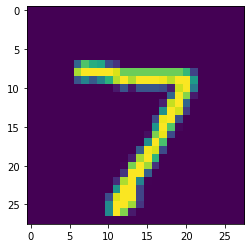

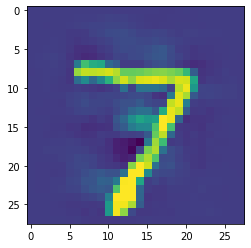

In [13]:
np_inputs = inputs.clone().cpu().detach().numpy()
np_advers = results[0]['adversaries'].clone().cpu().detach().numpy()

i = 0

plt.imshow(np.squeeze(np_inputs[i]))
plt.show()   

plt.imshow(np.squeeze(np_advers[i]))
plt.show()   

# Seeing if increasing neuron coverage effects the adversarial class

In [2]:
# load the results from file
with open('assets/results_mnist2019.08.17.pickle', 'rb') as handle:
    results = pickle.load(handle)

In [8]:
df = pd.DataFrame.from_dict(results)
target_features = ['attack', 
                   'layer', 
                   'regularization_weight', 
                   'orig_acc', 
                   'pert_acc', 
                   'neuron_coverage_000',
                   'neuron_coverage_020',
                   'neuron_coverage_050',
                   'neuron_coverage_075']
df[target_features]

,attack,layer,regularization_weight,orig_acc,pert_acc,neuron_coverage_000,neuron_coverage_020,neuron_coverage_050,neuron_coverage_075
0,cw_div4_attack,relu1-1,0,1.0,0.0,0.9482758621,0.2372742200,0.0660098522,0.0109688013
1,cw_div4_attack,relu1-1,1,1.0,0.0,0.9482101806,0.2371428571,0.0661412151,0.0110344828
2,cw_div4_attack,relu1-1,10,1.0,0.0,0.9483415435,0.2372742200,0.0665353038,0.0113628900
3,cw_div4_attack,relu1-1,100,1.0,0.0,0.9484072250,0.2376683087,0.0665353038,0.0113628900
4,cw_div4_attack,relu1-1,1000,1.0,0.0,0.9476190476,0.2418719212,0.0683087028,0.0120525452
5,cw_div4_attack,relu1-1,10000,1.0,0.0,0.9391461412,0.3030541872,0.0781609195,0.0137602627
6,cw_div4_attack,relu2-3,0,1.0,0.0,0.9483415435,0.2371428571,0.0664039409,0.0111658456
7,cw_div4_attack,relu2-3,1,1.0,0.0,0.9483415435,0.2369458128,0.0659441708,0.0109031199
8,cw_div4_attack,relu2-3,10,1.0,0.0,0.9480131363,0.2369458128,0.0661412151,0.0111001642
9,cw_div4_attack,relu2-3,100,1.0,0.0,0.9483415435,0.2368801314,0.0662725780,0.0111658456


## Logits Changes

In [132]:
logits_changes = []
# _, orig_counts = targets.unique(return_counts=True)
for result in results:
    pert_output = model(result['adversaries'])
    orig_output = model(inputs)
    # pert_pred = torch.argmax(pert_output, dim=1)
    # _, advs_counts = pert_pred.unique(return_counts=True)
    # class_changes.append(orig_counts)
    # class_changes.append(advs_counts)
    logits_changes.append((pert_output.sum(dim=0).int() - orig_output.sum(dim=0).int()).tolist())

In [133]:
normalized_logits_changes = []
for row in logits_changes:
    row_sum = sum(row)
    row = [round(x / row_sum, 3) for x in row]
    normalized_logits_changes.append(row)

In [134]:
normalized_logits_changes

[[0.089, 0.083, 0.092, 0.113, 0.098, 0.109, 0.105, 0.082, 0.112, 0.117],
 [0.089, 0.083, 0.092, 0.113, 0.098, 0.109, 0.105, 0.082, 0.112, 0.117],
 [0.088, 0.083, 0.093, 0.114, 0.098, 0.109, 0.105, 0.082, 0.112, 0.116],
 [0.088, 0.084, 0.093, 0.113, 0.098, 0.109, 0.105, 0.082, 0.112, 0.116],
 [0.09, 0.086, 0.097, 0.112, 0.096, 0.105, 0.106, 0.083, 0.115, 0.11],
 [0.1, 0.097, 0.109, 0.104, 0.087, 0.099, 0.116, 0.089, 0.108, 0.091],
 [0.089, 0.083, 0.092, 0.113, 0.098, 0.109, 0.105, 0.082, 0.112, 0.117],
 [0.089, 0.083, 0.092, 0.113, 0.098, 0.109, 0.105, 0.082, 0.112, 0.117],
 [0.089, 0.083, 0.093, 0.113, 0.098, 0.109, 0.105, 0.082, 0.112, 0.116],
 [0.089, 0.083, 0.092, 0.113, 0.098, 0.109, 0.105, 0.082, 0.112, 0.116],
 [0.09, 0.083, 0.096, 0.11, 0.097, 0.108, 0.105, 0.084, 0.115, 0.112],
 [0.1, 0.083, 0.102, 0.103, 0.094, 0.103, 0.106, 0.096, 0.122, 0.09],
 [0.089, 0.083, 0.093, 0.113, 0.098, 0.109, 0.105, 0.082, 0.112, 0.117],
 [0.089, 0.083, 0.092, 0.113, 0.098, 0.109, 0.105, 0.082, 0.

In [115]:
logits_changes

[[387, 363, 403, 495, 427, 476, 457, 357, 489, 511],
 [387, 364, 404, 495, 428, 476, 457, 357, 489, 511],
 [386, 364, 404, 496, 427, 476, 458, 358, 489, 508],
 [390, 369, 409, 499, 431, 481, 461, 361, 494, 512],
 [431, 412, 466, 538, 458, 502, 508, 397, 549, 525],
 [767, 742, 834, 799, 668, 758, 887, 679, 830, 693],
 [387, 364, 404, 495, 428, 475, 458, 358, 490, 509],
 [387, 364, 404, 495, 428, 476, 457, 358, 489, 510],
 [387, 364, 405, 495, 427, 475, 458, 358, 489, 508],
 [389, 366, 405, 496, 430, 478, 462, 360, 493, 510],
 [410, 377, 437, 502, 443, 492, 479, 385, 524, 510],
 [656, 546, 669, 672, 612, 675, 695, 631, 797, 592],
 [389, 365, 405, 496, 428, 477, 458, 359, 490, 511],
 [387, 364, 404, 495, 428, 476, 458, 357, 490, 509],
 [388, 365, 404, 495, 428, 476, 458, 358, 490, 511],
 [385, 366, 404, 493, 428, 474, 457, 357, 485, 506],
 [366, 381, 404, 472, 433, 463, 450, 360, 457, 481],
 [388, 504, 490, 457, 441, 511, 482, 454, 383, 407]]

In [131]:
torch.stack(logits_changes).var(dim=0)

tensor([11303.6230,  9638.0166, 13203.8291,  6760.9893,  4688.5737,  6178.8730,
        12462.7998,  9218.8359, 12183.6240,  2986.5505], device='cuda:0',
       grad_fn=<VarBackward1>)

In [106]:
torch.stack(logits_changes).mean(dim=0)

tensor([426.0808, 407.4556, 452.6254, 521.4553, 455.6634, 506.4740, 500.0867,
        400.1048, 523.6196, 518.2455], device='cuda:0',
       grad_fn=<MeanBackward2>)

## Class Changes

In [140]:
class_changes = []
_, orig_counts = targets.unique(return_counts=True)
for result in results:
    pert_output = model(result['adversaries'])
    pert_pred = torch.argmax(pert_output, dim=1)
    _, advs_counts = pert_pred.unique(return_counts=True)
    # class_changes.append(orig_counts)
    # class_changes.append(advs_counts)
    class_changes.append((advs_counts - orig_counts))

In [142]:
orig_counts

tensor([ 8, 14,  8, 11, 14,  7, 10, 15,  2, 11], device='cuda:0')

In [141]:
class_changes

[tensor([ -4, -10,   1,  -3,   4,   3,   2, -10,  11,   6], device='cuda:0'),
 tensor([ -4, -10,   1,  -3,   4,   3,   2, -10,  11,   6], device='cuda:0'),
 tensor([ -4, -10,   1,  -3,   4,   3,   2, -10,  11,   6], device='cuda:0'),
 tensor([ -4, -10,   1,  -3,   4,   3,   2, -10,  11,   6], device='cuda:0'),
 tensor([ -4, -10,   1,  -2,   3,   1,   2, -10,  14,   5], device='cuda:0'),
 tensor([ -3, -11,   5,  -4,  -5,   2,   0, -11,  24,   3], device='cuda:0'),
 tensor([ -4, -10,   1,  -3,   4,   3,   2, -10,  11,   6], device='cuda:0'),
 tensor([ -4, -10,   1,  -3,   4,   3,   2, -10,  11,   6], device='cuda:0'),
 tensor([ -4, -10,   1,  -3,   4,   3,   2, -10,  11,   6], device='cuda:0'),
 tensor([ -4, -10,   1,  -3,   4,   3,   2, -10,  11,   6], device='cuda:0'),
 tensor([ -4, -10,   2,  -4,   3,   3,   2,  -9,  11,   6], device='cuda:0'),
 tensor([ -4, -13,   3,  -4,  -5,   3,   0,  -7,  25,   2], device='cuda:0'),
 tensor([ -4, -10,   1,  -3,   4,   3,   2, -10,  11,   6], devi

In [69]:
torch.stack(class_changes).float().var(dim=0)

tensor([ 0.1732,  0.6928,  1.0752,  0.2647,  8.8235,  0.8235,  0.5000,  1.9085,
        20.9575,  1.9771], device='cuda:0')

In [70]:
torch.stack(class_changes).float().mean(dim=0)

tensor([ -4.0556, -10.1111,   1.3889,  -3.1667,   3.0000,   3.0000,   1.8333,
         -9.5556,  12.3889,   5.2778], device='cuda:0')

# Evaluating class changes with prior uniform distribution

In [17]:
data_dir = "C:\data\MNIST"
num_per_class = 30

dataset = torchvision.datasets.MNIST(root=data_dir, 
                                     train=False, 
                                     download=True,
                                     transform=transforms.Compose([
                                         transforms.ToTensor()
                                     ]))

class_distribution = torch.ones(len(dataset.targets.unique())) * num_per_class
inputs, targets = generate_batch(dataset, class_distribution, device)

In [72]:
# get original neuron coverage for this batch
eval_nc(model, inputs, 0.)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.51it/s]


(29347, 30450, 0.9637766830870279)

In [21]:
# load the results from file
with open('assets/results_mnist2019.08.17_30_per_class2.pkl', 'rb') as handle:
    results = pickle.load(handle)

In [134]:
# for result in results: 
#     i=99
#     np_advers = result['adversaries'].clone().cpu().detach().numpy() 
#     plt.imshow(np.squeeze(np_advers[i]))
#     plt.show()   

In [22]:
df = pd.DataFrame.from_dict(results)
target_features = ['attack', 
                   'layer', 
                   'regularization_weight', 
                   'orig_acc', 
                   'pert_acc', 
                   'neuron_coverage_000',
                   'neuron_coverage_020',
                   'neuron_coverage_050',
                   'neuron_coverage_075']
df[target_features]

,attack,layer,regularization_weight,orig_acc,pert_acc,neuron_coverage_000,neuron_coverage_020,neuron_coverage_050,neuron_coverage_075
0,cw_div4_attack,relu1-1,0,0.98,0.00,0.9684400657,0.2376354680,0.0675533662,0.0130049261
1,cw_div4_attack,relu1-1,1,0.98,0.00,0.9684400657,0.2377011494,0.0675533662,0.0130049261
2,cw_div4_attack,relu1-1,10,0.98,0.00,0.9685057471,0.2375041051,0.0676190476,0.0130706076
3,cw_div4_attack,relu1-1,100,0.98,0.00,0.9685714286,0.2375697865,0.0675533662,0.0130049261
4,cw_div4_attack,relu1-1,1000,0.98,0.00,0.9677175698,0.2393760263,0.0680131363,0.0127093596
5,cw_div4_attack,relu1-1,10000,0.98,0.00,0.9637766831,0.2577668309,0.0707717570,0.0133004926
6,cw_div4_attack,relu1-1,100000,0.98,0.09,0.9446633826,0.3356978654,0.0846305419,0.0178325123
7,cw_div4_attack,relu1-1,1000000,0.98,0.18,0.9600328407,0.3175369458,0.0833169130,0.0180295567
8,cw_div4_attack,relu2-3,0,0.98,0.00,0.9685057471,0.2376354680,0.0675533662,0.0130049261
9,cw_div4_attack,relu2-3,1,0.98,0.00,0.9685057471,0.2375697865,0.0675533662,0.0130049261


In [43]:
class_changes = []
orig_classes, orig_counts = targets.unique(return_counts=True)
for result in results:
    pert_output = model(result['adversaries'])
    pert_pred = torch.argmax(pert_output, dim=1)
    class_counts = []
    for i in orig_classes:
        count = 0
        for pred in pert_pred:
            if pred == i:
                count += 1
        class_counts.append(count)
    advs_counts = torch.tensor(class_counts)
    orig_counts = orig_counts.to(device)
    advs_counts = advs_counts.to(device)
    # _, advs_counts = pert_pred.unique(return_counts=True)
    # class_changes.append(orig_counts)
    # class_changes.append(advs_counts)
    class_changes.append((advs_counts - orig_counts))

In [45]:
orig_counts

tensor([30, 30, 30, 30, 30, 30, 30, 30, 30, 30], device='cuda:0')

In [47]:
class_changes

[tensor([-12, -14,  -6,  -2,  21,   3,   0, -10,   3,  17], device='cuda:0'),
 tensor([-12, -14,  -6,  -2,  21,   3,   0, -10,   3,  17], device='cuda:0'),
 tensor([-12, -14,  -6,  -2,  21,   3,   0, -10,   3,  17], device='cuda:0'),
 tensor([-12, -14,  -6,  -2,  21,   3,   0, -10,   4,  16], device='cuda:0'),
 tensor([-14, -14,  -6,  -3,  21,   3,   1, -11,   9,  14], device='cuda:0'),
 tensor([-13, -16,  -1,  -4,  16,   1,   0, -14,  24,   7], device='cuda:0'),
 tensor([-19, -28,   8,  17, -17,   2, -17, -25, 105, -26], device='cuda:0'),
 tensor([-19, -30,  14,  27, -23,  16, -21, -27,  91, -28], device='cuda:0'),
 tensor([-12, -14,  -6,  -2,  21,   3,   0, -10,   3,  17], device='cuda:0'),
 tensor([-12, -14,  -6,  -2,  21,   3,   0, -10,   3,  17], device='cuda:0'),
 tensor([-12, -14,  -6,  -2,  21,   3,   0, -10,   3,  17], device='cuda:0'),
 tensor([-12, -14,  -6,  -2,  21,   3,   0, -10,   4,  16], device='cuda:0'),
 tensor([-10, -16,  -7,  -2,  20,   2,   0,  -9,   8,  14], devi

# Heatmap Visualization

In [255]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

attack: cw_div4_attack - layer: relu1-1 - regularization_weight: 0 - confidence: 0 - pert_acc: 0.0


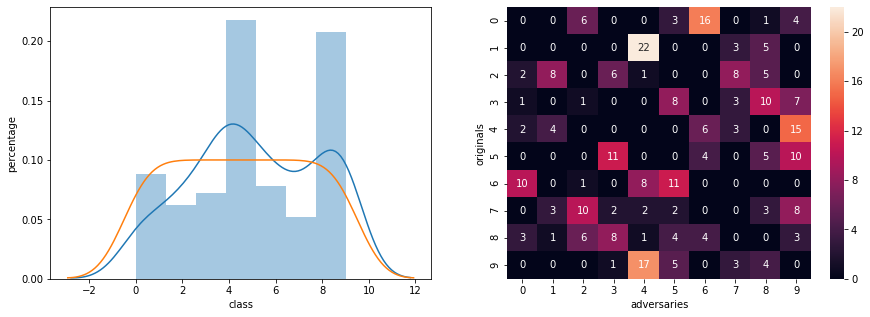

attack: cw_div4_attack - layer: relu1-1 - regularization_weight: 1 - confidence: 0 - pert_acc: 0.0


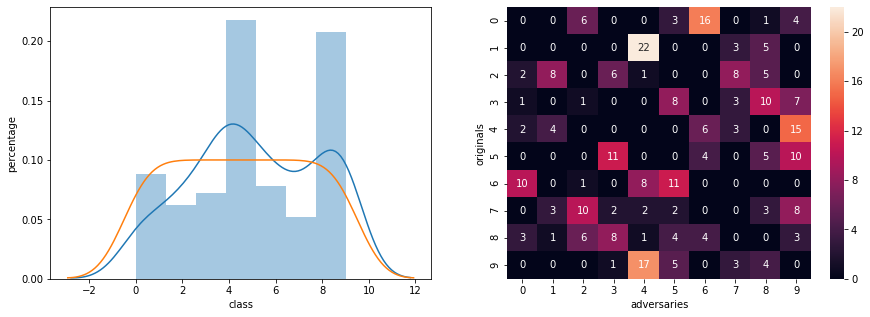

attack: cw_div4_attack - layer: relu1-1 - regularization_weight: 10 - confidence: 0 - pert_acc: 0.0


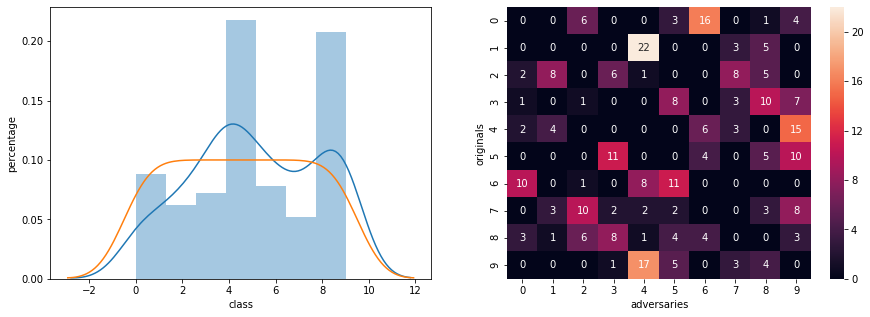

attack: cw_div4_attack - layer: relu1-1 - regularization_weight: 100 - confidence: 0 - pert_acc: 0.0


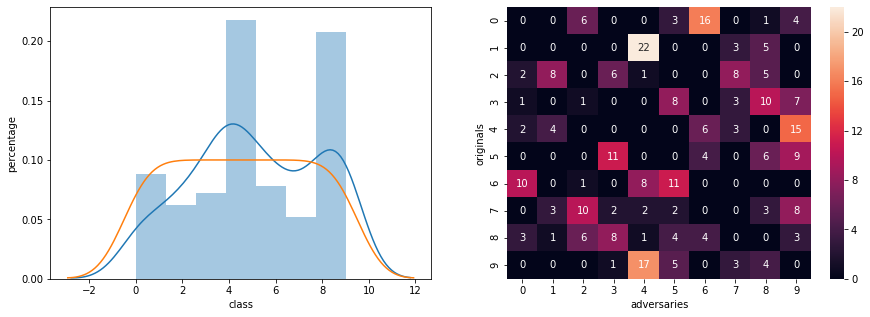

attack: cw_div4_attack - layer: relu1-1 - regularization_weight: 1000 - confidence: 0 - pert_acc: 0.0


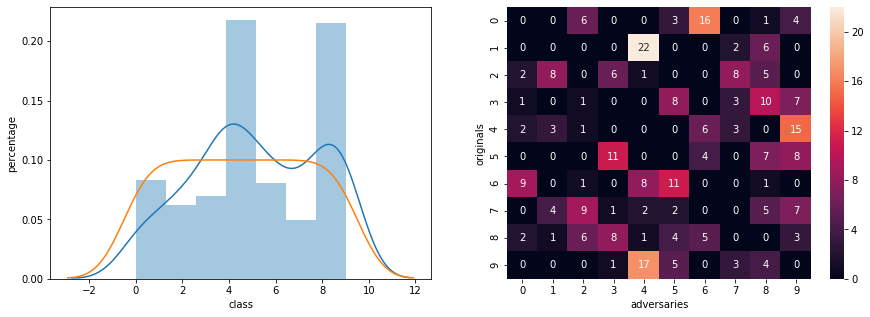

attack: cw_div4_attack - layer: relu1-1 - regularization_weight: 10000 - confidence: 0 - pert_acc: 0.0


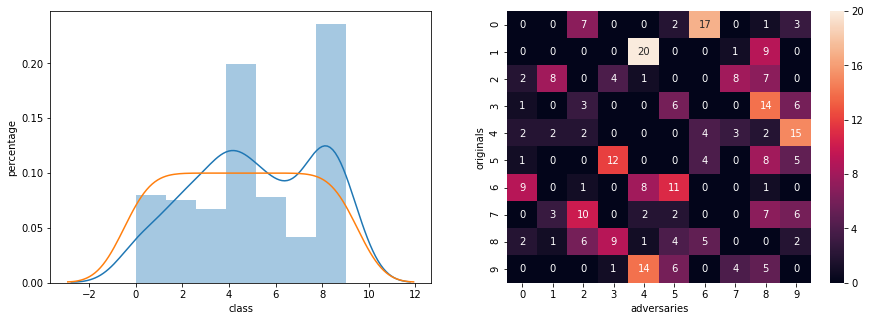

attack: cw_div4_attack - layer: relu1-1 - regularization_weight: 100000 - confidence: 0 - pert_acc: 0.09


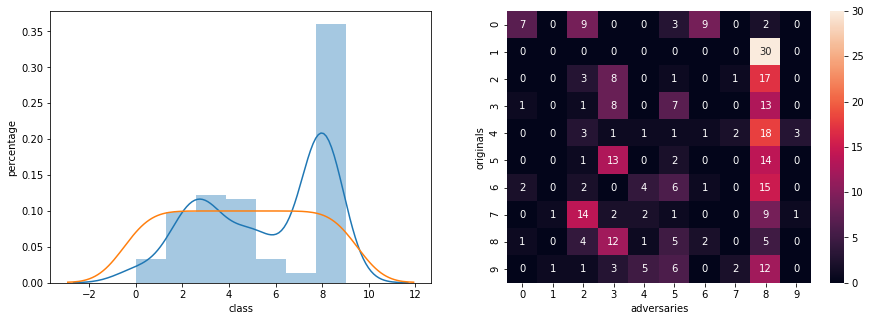

attack: cw_div4_attack - layer: relu1-1 - regularization_weight: 1000000 - confidence: 0 - pert_acc: 0.18


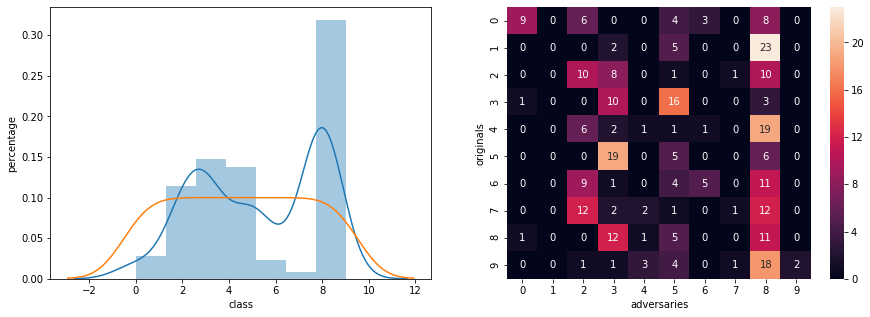

attack: cw_div4_attack - layer: relu2-3 - regularization_weight: 0 - confidence: 0 - pert_acc: 0.0


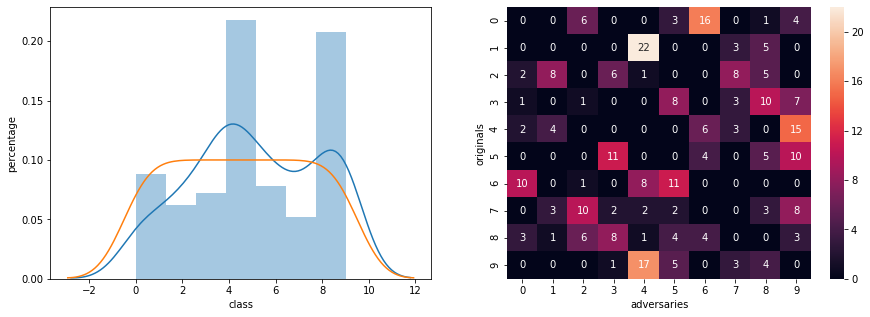

attack: cw_div4_attack - layer: relu2-3 - regularization_weight: 1 - confidence: 0 - pert_acc: 0.0


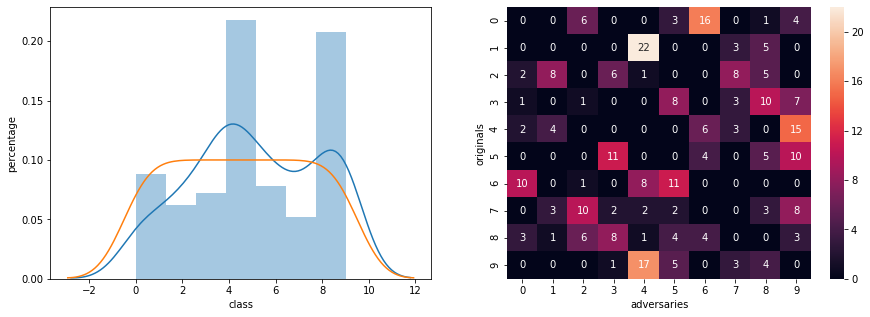

attack: cw_div4_attack - layer: relu2-3 - regularization_weight: 10 - confidence: 0 - pert_acc: 0.0


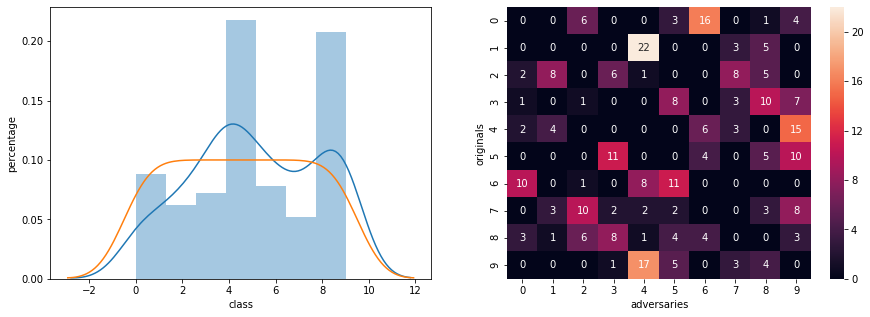

attack: cw_div4_attack - layer: relu2-3 - regularization_weight: 100 - confidence: 0 - pert_acc: 0.0


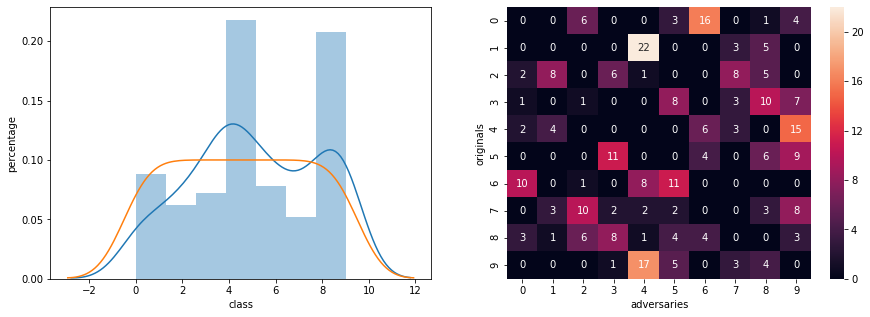

attack: cw_div4_attack - layer: relu2-3 - regularization_weight: 1000 - confidence: 0 - pert_acc: 0.0


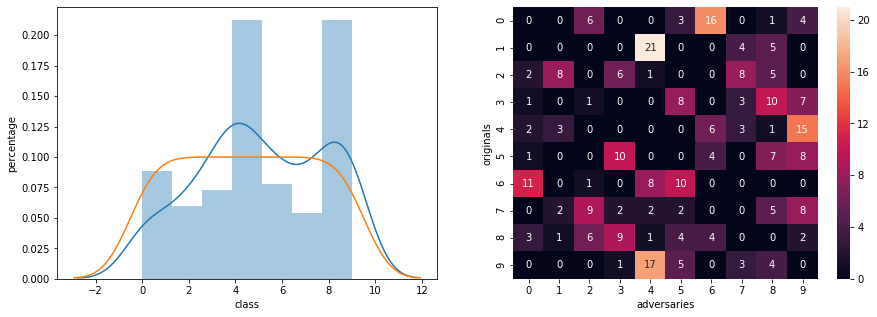

attack: cw_div4_attack - layer: relu2-3 - regularization_weight: 10000 - confidence: 0 - pert_acc: 0.0


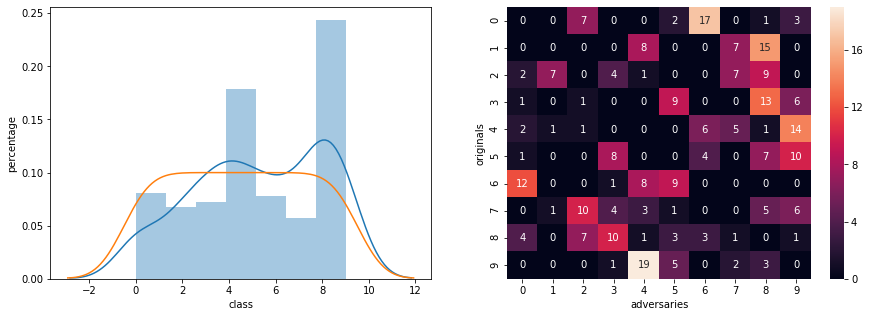

attack: cw_div4_attack - layer: relu2-3 - regularization_weight: 100000 - confidence: 0 - pert_acc: 0.0


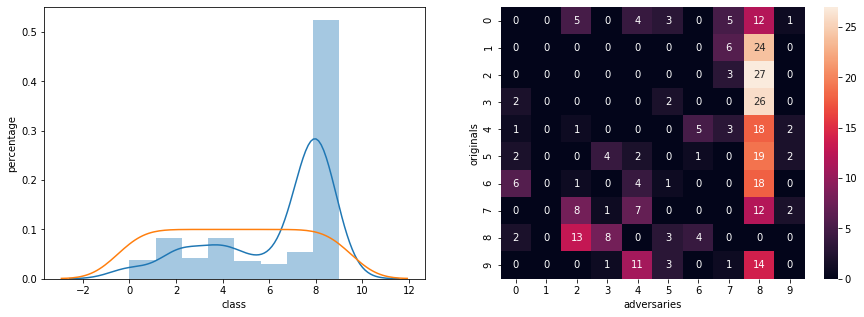

attack: cw_div4_attack - layer: relu2-3 - regularization_weight: 1000000 - confidence: 0 - pert_acc: 0.0


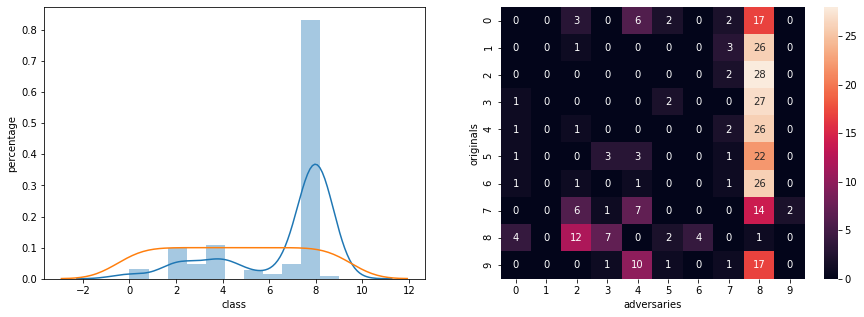

attack: cw_div4_attack - layer: relu3-5 - regularization_weight: 0 - confidence: 0 - pert_acc: 0.0


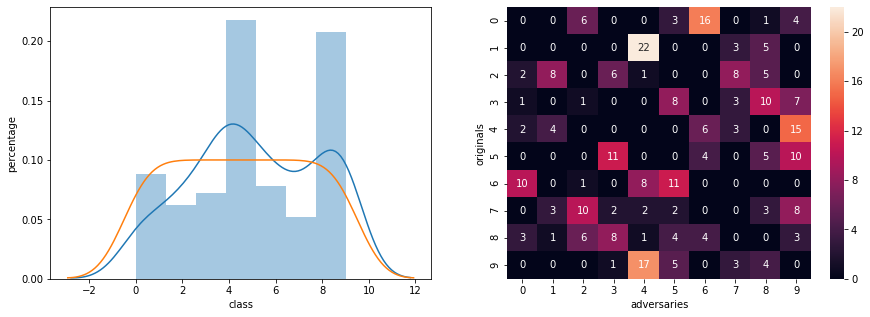

attack: cw_div4_attack - layer: relu3-5 - regularization_weight: 1 - confidence: 0 - pert_acc: 0.0


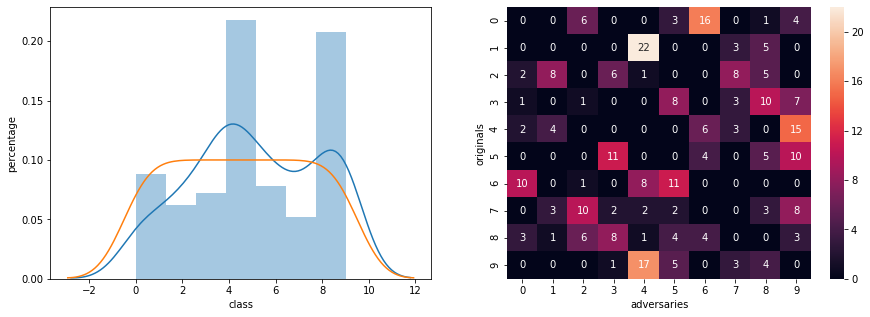

attack: cw_div4_attack - layer: relu3-5 - regularization_weight: 10 - confidence: 0 - pert_acc: 0.0


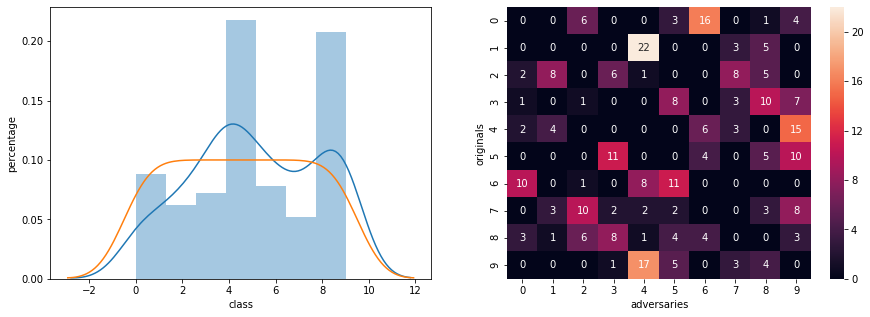

attack: cw_div4_attack - layer: relu3-5 - regularization_weight: 100 - confidence: 0 - pert_acc: 0.0


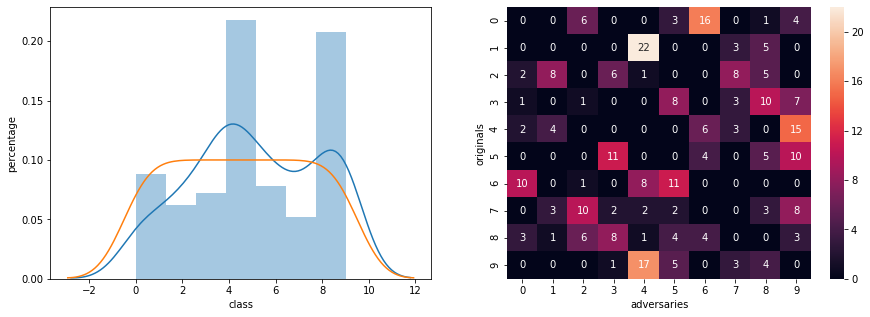

attack: cw_div4_attack - layer: relu3-5 - regularization_weight: 1000 - confidence: 0 - pert_acc: 0.0


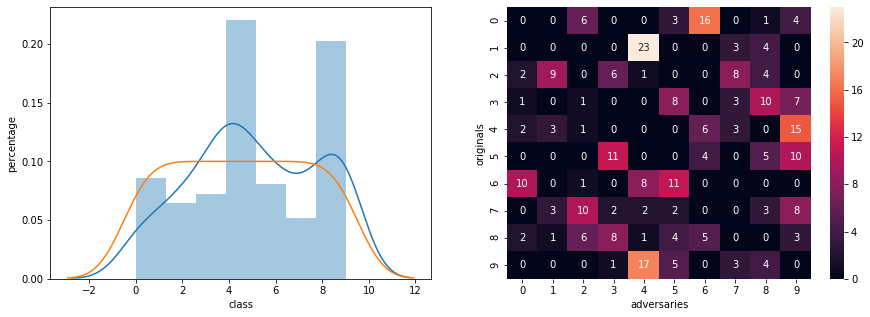

attack: cw_div4_attack - layer: relu3-5 - regularization_weight: 10000 - confidence: 0 - pert_acc: 0.0


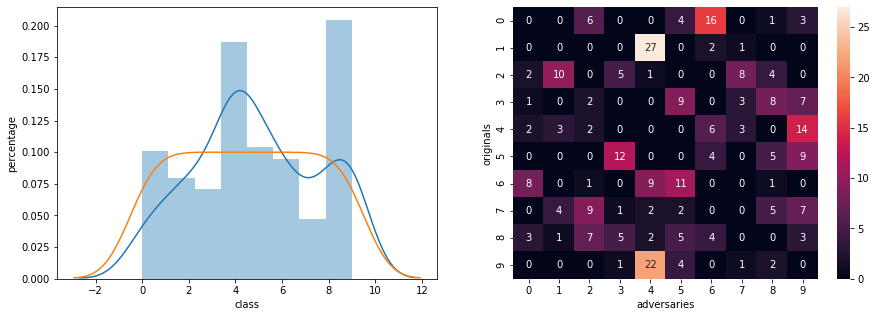

attack: cw_div4_attack - layer: relu3-5 - regularization_weight: 100000 - confidence: 0 - pert_acc: 0.0


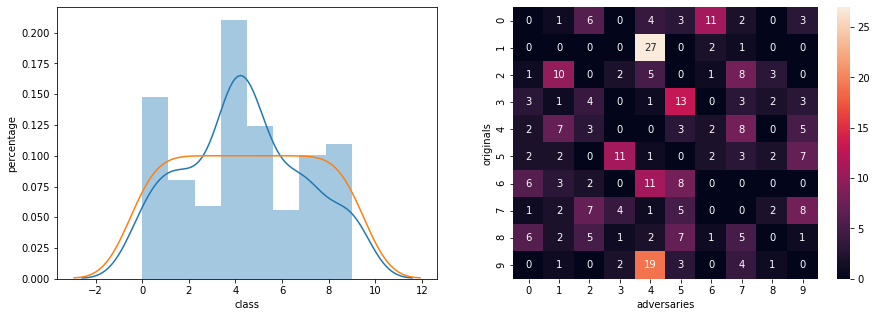

attack: cw_div4_attack - layer: relu3-5 - regularization_weight: 1000000 - confidence: 0 - pert_acc: 0.02


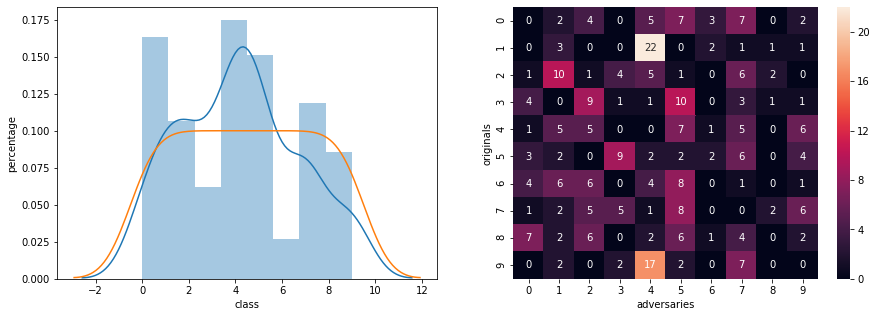

In [131]:
y_true = targets.cpu().numpy()
for result in results:
    
    # reference data
    attack = result['attack']
    layer = result['layer']
    rw = result['regularization_weight']
    conf = result['confidence']
    pert_acc = result['pert_acc']
    print('attack:', attack, '- layer:', layer, '- regularization_weight:', rw, '- confidence:', conf, '- pert_acc:', pert_acc)
    
    # adversary class predictions
    pert_output = model(result['adversaries'])
    y_pred = torch.argmax(pert_output, dim=1).cpu().numpy()
    
    # plots
    fig, ax = plt.subplots(1, 2, figsize = (15,5))

    # distplot
    sns.distplot(y_pred, ax=ax[0])
    sns.distplot(y_true, hist=False, ax=ax[0])
    ax[0].set_xlabel('class')
    ax[0].set_ylabel('percentage')
    
    # heatmap
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, ax=ax[1])
    ax[1].set_xlabel('adversaries')
    ax[1].set_ylabel('originals')
    
    plt.show()

# Diversity Regularization applied to ALL layers

In [38]:
# load the results from file
with open('assets/results_mnist2019.08.28_30_per_class.pkl', 'rb') as handle:
    results = pickle.load(handle)

In [136]:
df = pd.DataFrame.from_dict(results)
target_features = ['attack', 
                   'layer', 
                   'regularization_weight', 
                   'orig_acc', 
                   'pert_acc', 
                   'neuron_coverage_000',
                   'neuron_coverage_020',
                   'neuron_coverage_050',
                   'neuron_coverage_075']
df[target_features]

,attack,layer,regularization_weight,orig_acc,pert_acc,neuron_coverage_000,neuron_coverage_020,neuron_coverage_050,neuron_coverage_075
0,cw_div4_attack,all,1000000,0.98,0.07,0.9530049261,0.3430870279,0.0922495895,0.0162233169
1,cw_div4_attack,all,100000,0.98,0.05,0.9442692939,0.3347126437,0.0893924466,0.0158620690
2,cw_div4_attack,all,10000,0.98,0.00,0.9396715928,0.2986206897,0.0815106732,0.0147454844
3,cw_div4_attack,all,1000,0.98,0.00,0.9508374384,0.2488998358,0.0697208539,0.0126436782
4,cw_div4_attack,all,100,0.98,0.00,0.9519540230,0.2398357964,0.0672577997,0.0119211823
5,cw_div4_attack,all,10,0.98,0.00,0.9520197044,0.2390804598,0.0664696223,0.0120525452
6,cw_div4_attack,all,1,0.98,0.00,0.9523481117,0.2391461412,0.0665353038,0.0119868637
7,cw_div4_attack,all,0,0.98,0.00,0.9523481117,0.2392118227,0.0666666667,0.0119868637


attack: cw_div4_attack - layer: all - regularization_weight: 1000000 - confidence: 0 - pert_acc: 0.07 inception_score 1.6202225131202297


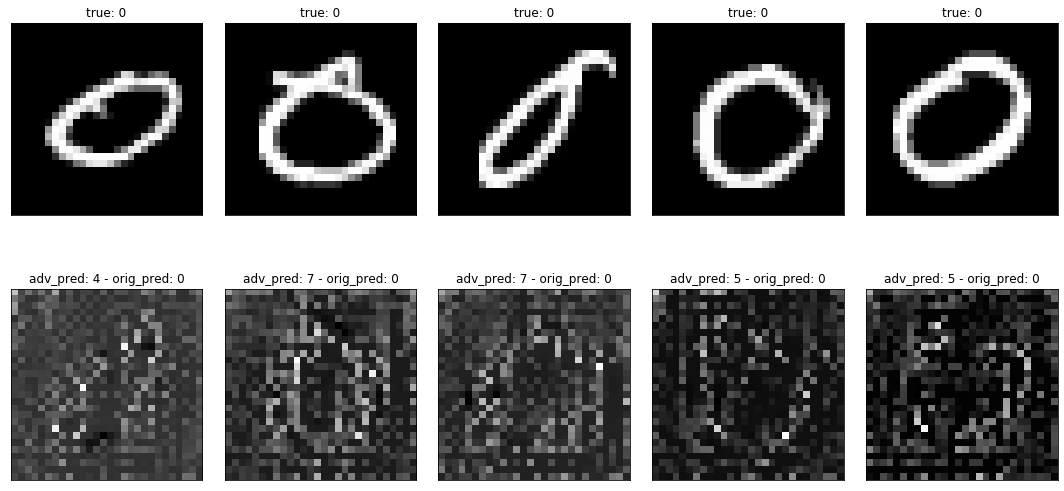

attack: cw_div4_attack - layer: all - regularization_weight: 100000 - confidence: 0 - pert_acc: 0.05 inception_score 1.6169476926473945


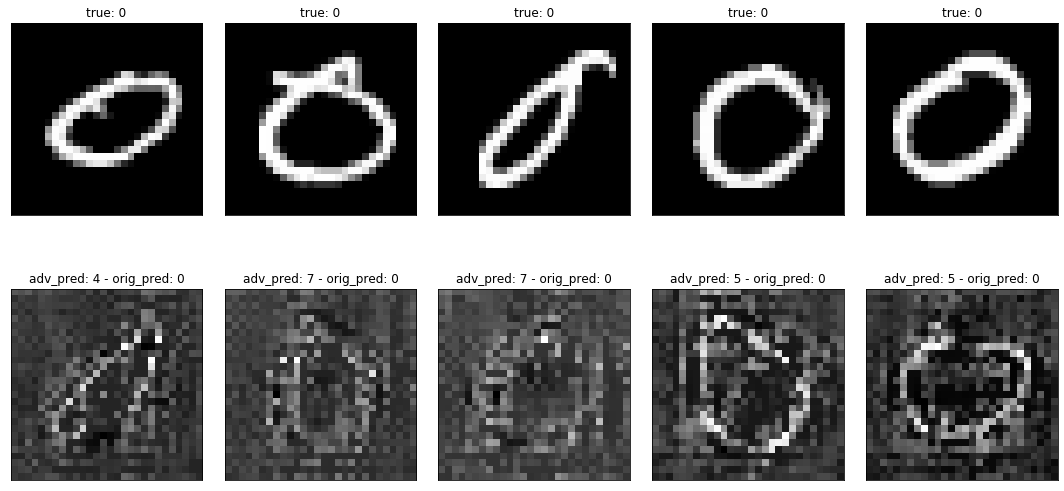

attack: cw_div4_attack - layer: all - regularization_weight: 10000 - confidence: 0 - pert_acc: 0.0 inception_score 1.8416837514647166


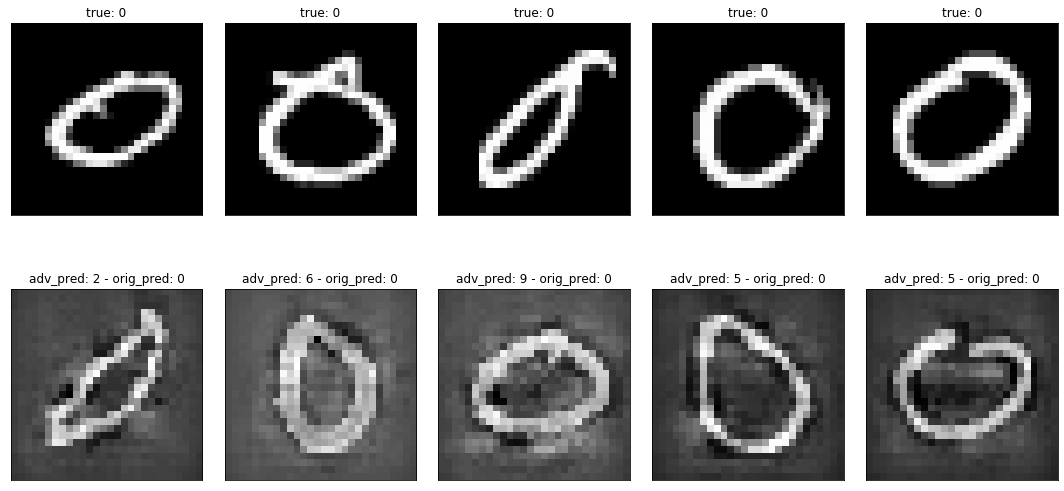

attack: cw_div4_attack - layer: all - regularization_weight: 1000 - confidence: 0 - pert_acc: 0.0 inception_score 1.6820005375275038


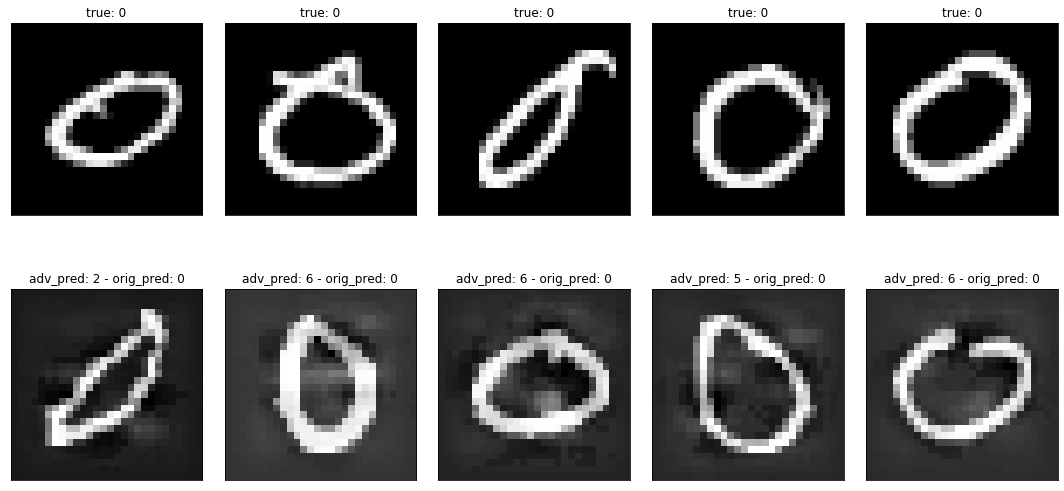

attack: cw_div4_attack - layer: all - regularization_weight: 100 - confidence: 0 - pert_acc: 0.0 inception_score 1.6760131150763922


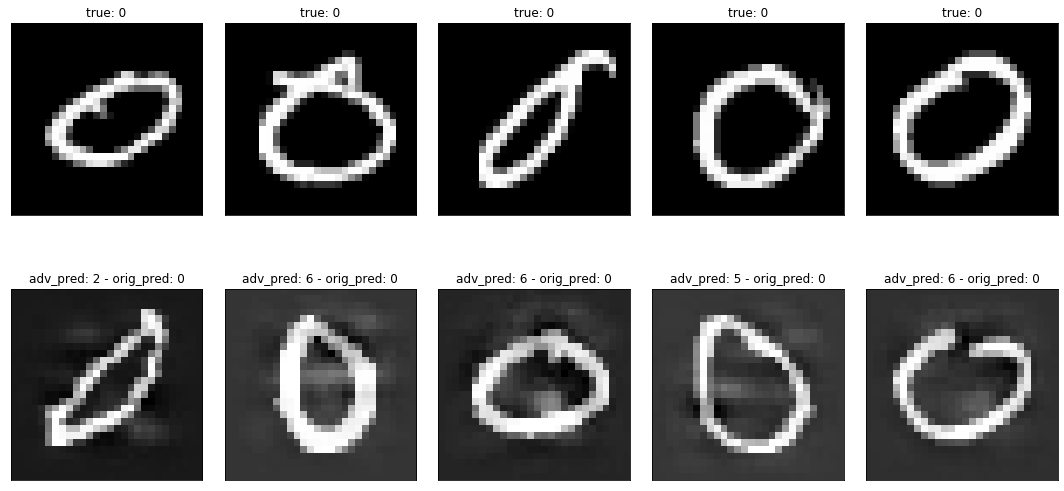

attack: cw_div4_attack - layer: all - regularization_weight: 10 - confidence: 0 - pert_acc: 0.0 inception_score 1.680690808231045


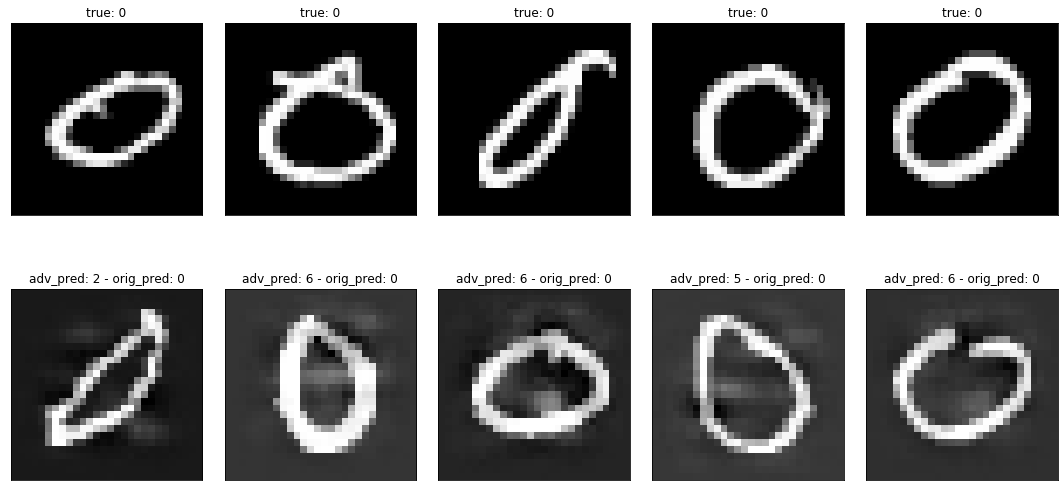

attack: cw_div4_attack - layer: all - regularization_weight: 1 - confidence: 0 - pert_acc: 0.0 inception_score 1.6838052364069083


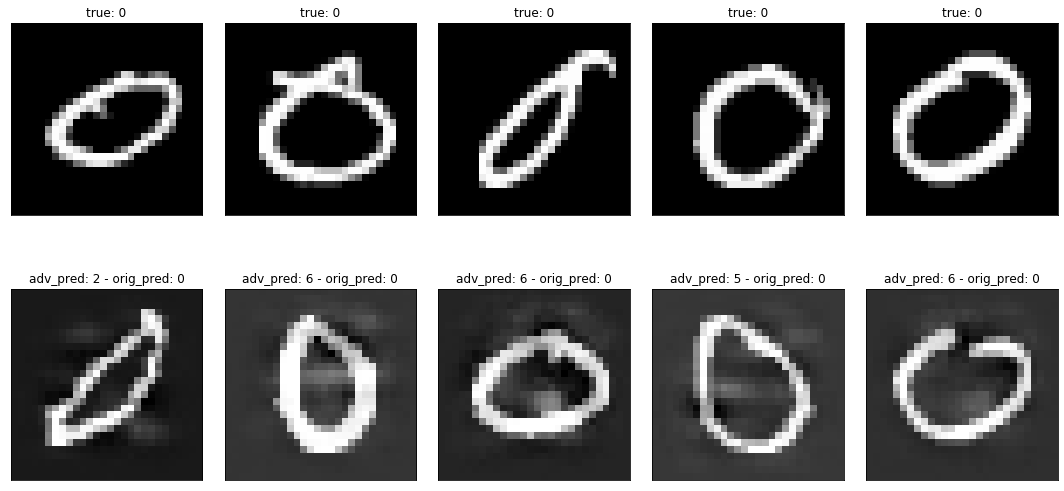

attack: cw_div4_attack - layer: all - regularization_weight: 0 - confidence: 0 - pert_acc: 0.0 inception_score 1.681519481659656


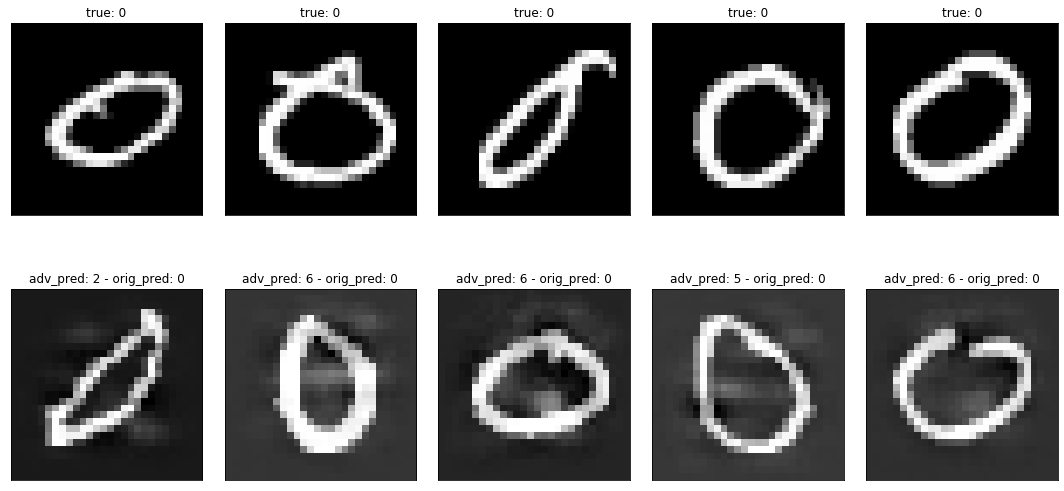

In [41]:
for result in results:
    
    # reference data
    attack = result['attack']
    layer = result['layer']
    rw = result['regularization_weight']
    conf = result['confidence']
    pert_acc = result['pert_acc']
    adversaries = result['adversaries']
    inception_score = result['inception_score']

    print('attack:', attack, '- layer:', layer, '- regularization_weight:', rw, '- confidence:', conf, '- pert_acc:', pert_acc, 'inception_score', inception_score)
        
    adversaries = result['adversaries']
    sample_1D_images(model, inputs, adversaries, targets)

# Layer Specific Activations

In [43]:
data_dir = "C:\data\MNIST"
num_per_class = 30

dataset = torchvision.datasets.MNIST(root=data_dir, 
                                     train=False, 
                                     download=True,
                                     transform=transforms.Compose([
                                         transforms.ToTensor()
                                     ]))

class_distribution = torch.ones(len(dataset.targets.unique())) * num_per_class
inputs, targets = generate_batch(dataset, class_distribution, device)

In [141]:
# load the results from file
with open('assets/results_mnist2019.08.17_30_per_class2.pkl', 'rb') as handle:
    results = pickle.load(handle)

In [45]:
df = pd.DataFrame.from_dict(results)
target_features = ['attack', 
                   'layer', 
                   'regularization_weight', 
                   'orig_acc', 
                   'pert_acc', 
                   'neuron_coverage_000',
                   'neuron_coverage_020',
                   'neuron_coverage_050',
                   'neuron_coverage_075']
df[target_features]

,attack,layer,regularization_weight,orig_acc,pert_acc,neuron_coverage_000,neuron_coverage_020,neuron_coverage_050,neuron_coverage_075
0,cw_div4_attack,relu1-1,0,0.98,0.00,0.9684400657,0.2376354680,0.0675533662,0.0130049261
1,cw_div4_attack,relu1-1,1,0.98,0.00,0.9684400657,0.2377011494,0.0675533662,0.0130049261
2,cw_div4_attack,relu1-1,10,0.98,0.00,0.9685057471,0.2375041051,0.0676190476,0.0130706076
3,cw_div4_attack,relu1-1,100,0.98,0.00,0.9685714286,0.2375697865,0.0675533662,0.0130049261
4,cw_div4_attack,relu1-1,1000,0.98,0.00,0.9677175698,0.2393760263,0.0680131363,0.0127093596
5,cw_div4_attack,relu1-1,10000,0.98,0.00,0.9637766831,0.2577668309,0.0707717570,0.0133004926
6,cw_div4_attack,relu1-1,100000,0.98,0.09,0.9446633826,0.3356978654,0.0846305419,0.0178325123
7,cw_div4_attack,relu1-1,1000000,0.98,0.18,0.9600328407,0.3175369458,0.0833169130,0.0180295567
8,cw_div4_attack,relu2-3,0,0.98,0.00,0.9685057471,0.2376354680,0.0675533662,0.0130049261
9,cw_div4_attack,relu2-3,1,0.98,0.00,0.9685057471,0.2375697865,0.0675533662,0.0130049261


In [22]:
nc_post_reg = {}

thresholds = [0., 0.2]

for t in thresholds:

    inputs_model_layer_dict = get_init_dict(model, inputs, False)
    update_coverage(model, inputs, inputs_model_layer_dict, threshold=t)

    for result in results:

        # reference data
        attack = result['attack']
        layer = result['layer']
        rw = result['regularization_weight']
        conf = result['confidence']
        pert_acc = result['pert_acc']
        adversaries = result['adversaries']

        print('attack:', attack, '- layer:', layer, '- regularization_weight:', rw, '- confidence:', conf, '- pert_acc:', pert_acc)

        o_covered_neurons, o_total_neurons, o_neuron_coverage = neurons_covered(inputs_model_layer_dict, layer)
        a_covered_neurons, a_total_neurons, a_neuron_coverage = eval_nc(model, adversaries, t, layer)
        
        pct_diff = (a_covered_neurons - o_covered_neurons) / o_covered_neurons

        print(o_covered_neurons, o_total_neurons, o_neuron_coverage)
        print(a_covered_neurons, a_total_neurons, a_neuron_coverage)
        
        nc_post_reg[(t, layer, rw, conf)] = {
            'o_covered_neurons':o_covered_neurons,
            'o_total_neurons':o_total_neurons,
            'o_neuron_coverage':o_neuron_coverage,
            'a_covered_neurons':a_covered_neurons,
            'a_total_neurons':a_total_neurons,
            'a_neuron_coverage':a_neuron_coverage,
            'pct_diff':pct_diff
        }


attack: cw_div4_attack - layer: relu1-1 - regularization_weight: 0 - confidence: 0 - pert_acc: 0.0



11107 11520 0.9641493055555556
11179 11520 0.9703993055555555
attack: cw_div4_attack - layer: relu1-1 - regularization_weight: 1 - confidence: 0 - pert_acc: 0.0



11107 11520 0.9641493055555556
11179 11520 0.9703993055555555
attack: cw_div4_attack - layer: relu1-1 - regularization_weight: 10 - confidence: 0 - pert_acc: 0.0



11107 11520 0.9641493055555556
11181 11520 0.9705729166666667
attack: cw_div4_attack - layer: relu1-1 - regularization_weight: 100 - confidence: 0 - pert_acc: 0.0



11107 11520 0.9641493055555556
11182 11520 0.9706597222222222
attack: cw_div4_attack - layer: relu1-1 - regularization_weight: 1000 - confidence: 0 - pert_acc: 0.0



11107 11520 0.9641493055555556
11179 11520 0.9703993055555555
attack: cw_div4_attack - layer: relu1-1 - regularization_weight: 10000 - confidence: 0 - pert_acc: 0.0



11107 11520 0.9641493055555556
11157 11520 0.9684895833333333
attack: cw_div4_attack - layer: relu1-1 - regularization_weight: 100000 - confidence: 0 - pert_acc: 0.09



11107 11520 0.9641493055555556
10887 11520 0.9450520833333333
attack: cw_div4_attack - layer: relu1-1 - regularization_weight: 1000000 - confidence: 0 - pert_acc: 0.18



11107 11520 0.9641493055555556
11115 11520 0.96484375
attack: cw_div4_attack - layer: relu2-3 - regularization_weight: 0 - confidence: 0 - pert_acc: 0.0



3094 3200 0.966875
3077 3200 0.9615625
attack: cw_div4_attack - layer: relu2-3 - regularization_weight: 1 - confidence: 0 - pert_acc: 0.0



3094 3200 0.966875
3077 3200 0.9615625
attack: cw_div4_attack - layer: relu2-3 - regularization_weight: 10 - confidence: 0 - pert_acc: 0.0



3094 3200 0.966875
3079 3200 0.9621875
attack: cw_div4_attack - layer: relu2-3 - regularization_weight: 100 - confidence: 0 - pert_acc: 0.0



3094 3200 0.966875
3076 3200 0.96125
attack: cw_div4_attack - layer: relu2-3 - regularization_weight: 1000 - confidence: 0 - pert_acc: 0.0



3094 3200 0.966875
3075 3200 0.9609375
attack: cw_div4_attack - layer: relu2-3 - regularization_weight: 10000 - confidence: 0 - pert_acc: 0.0



3094 3200 0.966875
3054 3200 0.954375
attack: cw_div4_attack - layer: relu2-3 - regularization_weight: 100000 - confidence: 0 - pert_acc: 0.0



3094 3200 0.966875
3022 3200 0.944375
attack: cw_div4_attack - layer: relu2-3 - regularization_weight: 1000000 - confidence: 0 - pert_acc: 0.0



3094 3200 0.966875
3023 3200 0.9446875
attack: cw_div4_attack - layer: relu3-5 - regularization_weight: 0 - confidence: 0 - pert_acc: 0.0



483 500 0.966
484 500 0.968
attack: cw_div4_attack - layer: relu3-5 - regularization_weight: 1 - confidence: 0 - pert_acc: 0.0



483 500 0.966
483 500 0.966
attack: cw_div4_attack - layer: relu3-5 - regularization_weight: 10 - confidence: 0 - pert_acc: 0.0



483 500 0.966
483 500 0.966
attack: cw_div4_attack - layer: relu3-5 - regularization_weight: 100 - confidence: 0 - pert_acc: 0.0



483 500 0.966
483 500 0.966
attack: cw_div4_attack - layer: relu3-5 - regularization_weight: 1000 - confidence: 0 - pert_acc: 0.0



483 500 0.966
485 500 0.97
attack: cw_div4_attack - layer: relu3-5 - regularization_weight: 10000 - confidence: 0 - pert_acc: 0.0



483 500 0.966
489 500 0.978
attack: cw_div4_attack - layer: relu3-5 - regularization_weight: 100000 - confidence: 0 - pert_acc: 0.0



483 500 0.966
496 500 0.992
attack: cw_div4_attack - layer: relu3-5 - regularization_weight: 1000000 - confidence: 0 - pert_acc: 0.02



483 500 0.966
498 500 0.996



attack: cw_div4_attack - layer: relu1-1 - regularization_weight: 0 - confidence: 0 - pert_acc: 0.0



1661 11520 0.14418402777777778
1737 11520 0.15078125
attack: cw_div4_attack - layer: relu1-1 - regularization_weight: 1 - confidence: 0 - pert_acc: 0.0



1661 11520 0.14418402777777778
1737 11520 0.15078125
attack: cw_div4_attack - layer: relu1-1 - regularization_weight: 10 - confidence: 0 - pert_acc: 0.0



1661 11520 0.14418402777777778
1736 11520 0.15069444444444444
attack: cw_div4_attack - layer: relu1-1 - regularization_weight: 100 - confidence: 0 - pert_acc: 0.0



1661 11520 0.14418402777777778
1735 11520 0.1506076388888889
attack: cw_div4_attack - layer: relu1-1 - regularization_weight: 1000 - confidence: 0 - pert_acc: 0.0



1661 11520 0.14418402777777778
1759 11520 0.15269097222222222
attack: cw_div4_attack - layer: relu1-1 - regularization_weight: 10000 - confidence: 0 - pert_acc: 0.0



1661 11520 0.14418402777777778
2099 11520 0.18220486111111112
attack: cw_div4_attack - layer: relu1-1 - regularization_weight: 100000 - confidence: 0 - pert_acc: 0.09



1661 11520 0.14418402777777778
3676 11520 0.3190972222222222
attack: cw_div4_attack - layer: relu1-1 - regularization_weight: 1000000 - confidence: 0 - pert_acc: 0.18



1661 11520 0.14418402777777778
3278 11520 0.2845486111111111
attack: cw_div4_attack - layer: relu2-3 - regularization_weight: 0 - confidence: 0 - pert_acc: 0.0



1564 3200 0.48875
1572 3200 0.49125
attack: cw_div4_attack - layer: relu2-3 - regularization_weight: 1 - confidence: 0 - pert_acc: 0.0



1564 3200 0.48875
1571 3200 0.4909375
attack: cw_div4_attack - layer: relu2-3 - regularization_weight: 10 - confidence: 0 - pert_acc: 0.0



1564 3200 0.48875
1571 3200 0.4909375
attack: cw_div4_attack - layer: relu2-3 - regularization_weight: 100 - confidence: 0 - pert_acc: 0.0



1564 3200 0.48875
1572 3200 0.49125
attack: cw_div4_attack - layer: relu2-3 - regularization_weight: 1000 - confidence: 0 - pert_acc: 0.0



1564 3200 0.48875
1566 3200 0.489375
attack: cw_div4_attack - layer: relu2-3 - regularization_weight: 10000 - confidence: 0 - pert_acc: 0.0



1564 3200 0.48875
1501 3200 0.4690625
attack: cw_div4_attack - layer: relu2-3 - regularization_weight: 100000 - confidence: 0 - pert_acc: 0.0



1564 3200 0.48875
1294 3200 0.404375
attack: cw_div4_attack - layer: relu2-3 - regularization_weight: 1000000 - confidence: 0 - pert_acc: 0.0



1564 3200 0.48875
1287 3200 0.4021875
attack: cw_div4_attack - layer: relu3-5 - regularization_weight: 0 - confidence: 0 - pert_acc: 0.0



308 500 0.616
305 500 0.61
attack: cw_div4_attack - layer: relu3-5 - regularization_weight: 1 - confidence: 0 - pert_acc: 0.0



308 500 0.616
306 500 0.612
attack: cw_div4_attack - layer: relu3-5 - regularization_weight: 10 - confidence: 0 - pert_acc: 0.0



308 500 0.616
305 500 0.61
attack: cw_div4_attack - layer: relu3-5 - regularization_weight: 100 - confidence: 0 - pert_acc: 0.0



308 500 0.616
305 500 0.61
attack: cw_div4_attack - layer: relu3-5 - regularization_weight: 1000 - confidence: 0 - pert_acc: 0.0



308 500 0.616
311 500 0.622
attack: cw_div4_attack - layer: relu3-5 - regularization_weight: 10000 - confidence: 0 - pert_acc: 0.0



308 500 0.616
337 500 0.674
attack: cw_div4_attack - layer: relu3-5 - regularization_weight: 100000 - confidence: 0 - pert_acc: 0.0



308 500 0.616
366 500 0.732
attack: cw_div4_attack - layer: relu3-5 - regularization_weight: 1000000 - confidence: 0 - pert_acc: 0.02



308 500 0.616
378 500 0.756


In [30]:
df = pd.DataFrame.from_dict(nc_post_reg)
df.T

o_covered_neurons  o_total_neurons  o_neuron_coverage  \
0.0 relu1-1 0       0            11107.0          11520.0       0.9641493056   
            1       0            11107.0          11520.0       0.9641493056   
            10      0            11107.0          11520.0       0.9641493056   
            100     0            11107.0          11520.0       0.9641493056   
            1000    0            11107.0          11520.0       0.9641493056   
            10000   0            11107.0          11520.0       0.9641493056   
            100000  0            11107.0          11520.0       0.9641493056   
            1000000 0            11107.0          11520.0       0.9641493056   
    relu2-3 0       0             3094.0           3200.0       0.9668750000   
            1       0             3094.0           3200.0       0.9668750000   
            10      0             3094.0           3200.0       0.9668750000   
            100     0             3094.0           3200.0       0.9668750000   
            1000    0             3094.0           3200.0       0.9668750000   
            10000   0             3094.0           3200.0       0.9668750000   
            100000  0             3094.0           3200.0       0.9668750000   
            1000000 0             3094.0           3200.0       0.9668750000   
    relu3-5 0       0              483.0            500.0       0.9660000000   
            1       0              483.0            500.0       0.9660000000   
            10      0              483.0            500.0       0.9660000000   
            100     0              483.0            500.0       0.9660000000   
            1000    0              483.0            500.0       0.9660000000   
            10000   0              483.0            500.0       0.9660000000   
            100000  0              483.0            500.0       0.9660000000   
            1000000 0              483.0            500.0       0.9660000000   
0.2 relu1-1 0       0             1661.0          11520.0       0.1441840278   
            1       0             1661.0          11520.0       0.1441840278   
            10      0             1661.0          11520.0       0.1441840278   
            100     0             1661.0          11520.0       0.1441840278   
            1000    0             1661.0          11520.0       0.1441840278   
            10000   0             1661.0          11520.0       0.1441840278   
            100000  0             1661.0          11520.0       0.1441840278   
            1000000 0             1661.0          11520.0       0.1441840278   
    relu2-3 0       0             1564.0           3200.0       0.4887500000   
            1       0             1564.0           3200.0       0.4887500000   
            10      0             1564.0           3200.0       0.4887500000   
            100     0             1564.0           3200.0       0.4887500000   
            1000    0             1564.0           3200.0       0.4887500000   
            10000   0             1564.0           3200.0       0.4887500000   
            100000  0             1564.0           3200.0       0.4887500000   
            1000000 0             1564.0           3200.0       0.4887500000   
    relu3-5 0       0              308.0            500.0       0.6160000000   
            1       0              308.0            500.0       0.6160000000   
            10      0              308.0            500.0       0.6160000000   
            100     0              308.0            500.0       0.6160000000   
            1000    0              308.0            500.0       0.6160000000   
            10000   0              308.0            500.0       0.6160000000   
            100000  0              308.0            500.0       0.6160000000   
            1000000 0              308.0            500.0       0.6160000000   

                       a_covered_neurons  a_total_neurons  a_neuron_coverage  \
0.0 relu1-1 0       0 

In [34]:
df.T['pct_diff'].mean()

0.058597660980840106

In [32]:
save_file_path = "assets/nc_post_reg_mnist.pkl"
pickle.dump(nc_post_reg, open(save_file_path, "wb")) 

# Investigating small NC threshold behavior

In [55]:
data_dir = "C:\data\MNIST"
num_per_class = 30

dataset = torchvision.datasets.MNIST(root=data_dir, 
                                     train=False, 
                                     download=True,
                                     transform=transforms.Compose([
                                         transforms.ToTensor()
                                     ]))

class_distribution = torch.ones(len(dataset.targets.unique())) * num_per_class
inputs, targets = generate_batch(dataset, class_distribution, device)

In [62]:
nc_per_threshold = {}

thresholds = np.linspace(0, 1, 101)

for t in thresholds:
    
    print('threshold', t)
    
    covered_neurons, total_neurons, neuron_coverage = eval_nc(model, inputs, t)
    
    print(covered_neurons, total_neurons, neuron_coverage)

    nc_per_threshold[t] = {
        'covered_neurons':covered_neurons,
        'total_neurons':total_neurons,
        'neuron_coverage':neuron_coverage
    }

threshold 0.0



29475 30450 0.9679802955665024
threshold 0.01



24821 30450 0.8151395730706076
threshold 0.02



23257 30450 0.763776683087028
threshold 0.03



21445 30450 0.7042692939244664
threshold 0.04



19051 30450 0.6256486042692939
threshold 0.05



16719 30450 0.5490640394088669
threshold 0.06



15197 30450 0.49908045977011495
threshold 0.07



13853 30450 0.4549425287356322
threshold 0.08



13009 30450 0.4272249589490969
threshold 0.09



12295 30450 0.4037766830870279
threshold 0.1



11537 30450 0.3788834154351396
threshold 0.11



10921 30450 0.3586535303776683
threshold 0.12



10299 30450 0.33822660098522167
threshold 0.13



9843 30450 0.3232512315270936
threshold 0.14



9359 30450 0.30735632183908046
threshold 0.15



8903 30450 0.2923809523809524
threshold 0.16



8525 30450 0.2799671592775041
threshold 0.17



8151 30450 0.2676847290640394
threshold 0.18



7791 30450 0.2558620689655172
threshold 0.19



7429 30450 0.2439737274220033
threshold 0.2



7077 30450 0.23241379310344829
threshold 0.21



6747 30450 0.22157635467980297
threshold 0.22



6463 30450 0.2122495894909688
threshold 0.23



6141 30450 0.20167487684729063
threshold 0.24



5847 30450 0.19201970443349753
threshold 0.25



5571 30450 0.18295566502463054
threshold 0.26



5321 30450 0.17474548440065682
threshold 0.27



5059 30450 0.16614121510673235
threshold 0.28



4859 30450 0.15957307060755338
threshold 0.29



4656 30450 0.1529064039408867
threshold 0.3



4437 30450 0.1457142857142857
threshold 0.31



4259 30450 0.13986863711001643
threshold 0.32



4081 30450 0.13402298850574712
threshold 0.33



3919 30450 0.12870279146141214
threshold 0.34



3741 30450 0.12285714285714286
threshold 0.35000000000000003



3585 30450 0.11773399014778325
threshold 0.36



3451 30450 0.11333333333333333
threshold 0.37



3311 30450 0.10873563218390804
threshold 0.38



3152 30450 0.10351395730706076
threshold 0.39



3000 30450 0.09852216748768473
threshold 0.4



2886 30450 0.0947783251231527
threshold 0.41000000000000003



2780 30450 0.09129720853858785
threshold 0.42



2682 30450 0.08807881773399015
threshold 0.43



2608 30450 0.08564860426929392
threshold 0.44



2496 30450 0.08197044334975369
threshold 0.45



2398 30450 0.07875205254515599
threshold 0.46



2291 30450 0.07523809523809524
threshold 0.47000000000000003



2205 30450 0.07241379310344828
threshold 0.48



2107 30450 0.06919540229885057
threshold 0.49



2039 30450 0.06696223316912972
threshold 0.5



1957 30450 0.06426929392446634
threshold 0.51



1879 30450 0.06170771756978653
threshold 0.52



1775 30450 0.05829228243021346
threshold 0.53



1697 30450 0.05573070607553366
threshold 0.54



1629 30450 0.05349753694581281
threshold 0.55



1559 30450 0.051198686371100165
threshold 0.56



1493 30450 0.0490311986863711
threshold 0.5700000000000001



1415 30450 0.046469622331691295
threshold 0.58



1347 30450 0.04423645320197044
threshold 0.59



1275 30450 0.04187192118226601
threshold 0.6



1207 30450 0.039638752052545155
threshold 0.61



1142 30450 0.03750410509031199
threshold 0.62



1082 30450 0.03553366174055829
threshold 0.63



1030 30450 0.033825944170771755
threshold 0.64



966 30450 0.031724137931034485
threshold 0.65



904 30450 0.029688013136288997
threshold 0.66



846 30450 0.027783251231527094
threshold 0.67



798 30450 0.02620689655172414
threshold 0.68



738 30450 0.024236453201970442
threshold 0.6900000000000001



698 30450 0.02292282430213465
threshold 0.7000000000000001



614 30450 0.020164203612479475
threshold 0.71



570 30450 0.0187192118226601
threshold 0.72



518 30450 0.017011494252873564
threshold 0.73



467 30450 0.015336617405582923
threshold 0.74



417 30450 0.013694581280788177
threshold 0.75



385 30450 0.01264367816091954
threshold 0.76



347 30450 0.011395730706075533
threshold 0.77



323 30450 0.010607553366174055
threshold 0.78



301 30450 0.009885057471264367
threshold 0.79



265 30450 0.008702791461412151
threshold 0.8



233 30450 0.007651888341543514
threshold 0.81



207 30450 0.0067980295566502464
threshold 0.8200000000000001



185 30450 0.006075533661740558
threshold 0.8300000000000001



169 30450 0.00555008210180624
threshold 0.84



157 30450 0.005155993431855501
threshold 0.85



147 30450 0.004827586206896552
threshold 0.86



139 30450 0.0045648604269293925
threshold 0.87



126 30450 0.004137931034482759
threshold 0.88



112 30450 0.0036781609195402297
threshold 0.89



92 30450 0.0030213464696223317
threshold 0.9



84 30450 0.002758620689655172
threshold 0.91



70 30450 0.0022988505747126436
threshold 0.92



64 30450 0.002101806239737274
threshold 0.93



48 30450 0.0015763546798029558
threshold 0.9400000000000001



42 30450 0.001379310344827586
threshold 0.9500000000000001



34 30450 0.001116584564860427
threshold 0.96



26 30450 0.0008538587848932677
threshold 0.97



23 30450 0.0007553366174055829
threshold 0.98



21 30450 0.000689655172413793
threshold 0.99



11 30450 0.000361247947454844
threshold 1.0



0 30450 0.0


In [122]:
df = pd.DataFrame.from_dict(nc_per_threshold).T
df.reset_index(level=0, inplace=True)
df.rename(columns={"index": "threshold"}, inplace=True)
df

,threshold,covered_neurons,total_neurons,neuron_coverage
0,0.00,29475.0,30450.0,0.9679802956
1,0.01,24821.0,30450.0,0.8151395731
2,0.02,23257.0,30450.0,0.7637766831
3,0.03,21445.0,30450.0,0.7042692939
4,0.04,19051.0,30450.0,0.6256486043
5,0.05,16719.0,30450.0,0.5490640394
6,0.06,15197.0,30450.0,0.4990804598
7,0.07,13853.0,30450.0,0.4549425287
8,0.08,13009.0,30450.0,0.4272249589
9,0.09,12295.0,30450.0,0.4037766831


In [102]:
df.corr()

,threshold,covered_neurons,total_neurons,neuron_coverage
threshold,1.0000000000,-0.8076412826,NaN,-0.8076412826
covered_neurons,-0.8076412826,1.0000000000,NaN,1.0000000000
total_neurons,NaN,NaN,NaN,NaN
neuron_coverage,-0.8076412826,1.0000000000,NaN,1.0000000000


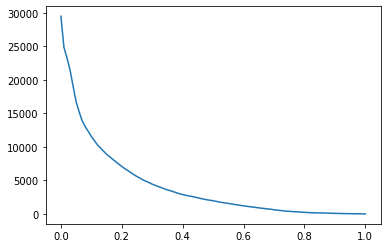

In [123]:
X = df['threshold'].values.reshape(-1, 1)
y = df['covered_neurons'].values.reshape(-1, 1)
plt.plot(X, y)

In [89]:
save_file_path = "assets/nc_threshold_analysis_mnist.pkl"
pickle.dump(nc_per_threshold, open(save_file_path, "wb")) 

# Investigating how Adversarial Perturbation Affects NC distribution

In [167]:
nc_per_threshold_adv = {}

thresholds = np.linspace(0, 1, 101)

for result in results:
    
    # reference data
    attack = result['attack']
    layer = result['layer']
    rw = result['regularization_weight']
    conf = result['confidence']
    pert_acc = result['pert_acc']
    adversaries = result['adversaries']

    print('attack:', attack, '- layer:', layer, '- regularization_weight:', rw, '- confidence:', conf, '- pert_acc:', pert_acc)

    for t in thresholds:

        print('threshold', t)

        covered_neurons, total_neurons, neuron_coverage = eval_nc(model, adversaries, t)

        print(covered_neurons, total_neurons, neuron_coverage)

        nc_per_threshold_adv[(t, layer, rw, conf)] = {
            'covered_neurons':covered_neurons,
            'total_neurons':total_neurons,
            'neuron_coverage':neuron_coverage
        }

{('relu1-1', 0, 0): {}}
attack: cw_div4_attack - layer: relu1-1 - regularization_weight: 0 - confidence: 0 - pert_acc: 0.0
threshold 0.0



29489 30450 0.968440065681445
{('relu1-1', 0, 0): {0.0: {'covered_neurons': 29489, 'total_neurons': 30450, 'neuron_coverage': 0.968440065681445}}}
threshold 0.01



24983 30450 0.8204597701149425
{('relu1-1', 0, 0): {0.0: {'covered_neurons': 29489, 'total_neurons': 30450, 'neuron_coverage': 0.968440065681445}, 0.01: {'covered_neurons': 24983, 'total_neurons': 30450, 'neuron_coverage': 0.8204597701149425}}}
threshold 0.02



23283 30450 0.7646305418719211
{('relu1-1', 0, 0): {0.0: {'covered_neurons': 29489, 'total_neurons': 30450, 'neuron_coverage': 0.968440065681445}, 0.01: {'covered_neurons': 24983, 'total_neurons': 30450, 'neuron_coverage': 0.8204597701149425}, 0.02: {'covered_neurons': 23283, 'total_neurons': 30450, 'neuron_coverage': 0.7646305418719211}}}
threshold 0.03



21463 30450 0.7048604269293924
{('relu1-1', 0, 0): {0.0: {'covered_neurons': 29489, 'total_neurons': 30450, 'neuron_coverage': 0.968440065681445}, 0.01: {'covered_neurons': 24983, 'total_neurons': 30450, 'neuron_coverage': 0.8204597701149425}, 0.02: {'covered_neurons': 23283, 'total_neurons': 30450, 'neuron_coverage': 0.7646305418719211}, 0.03: {'covered_neurons': 21463, 'total_neurons': 30450, 'neuron_coverage': 0.7048604269293924}}}
threshold 0.04



19237 30450 0.6317569786535304
{('relu1-1', 0, 0): {0.0: {'covered_neurons': 29489, 'total_neurons': 30450, 'neuron_coverage': 0.968440065681445}, 0.01: {'covered_neurons': 24983, 'total_neurons': 30450, 'neuron_coverage': 0.8204597701149425}, 0.02: {'covered_neurons': 23283, 'total_neurons': 30450, 'neuron_coverage': 0.7646305418719211}, 0.03: {'covered_neurons': 21463, 'total_neurons': 30450, 'neuron_coverage': 0.7048604269293924}, 0.04: {'covered_neurons': 19237, 'total_neurons': 30450, 'neuron_coverage': 0.6317569786535304}}}
threshold 0.05


KeyboardInterrupt: 

In [147]:
save_file_path = "assets/nc_threshold_analysis_adv_mnist.pkl"
pickle.dump(nc_per_threshold_adv, open(save_file_path, "wb")) 

In [172]:
df_adv = pd.DataFrame.from_dict(nc_per_threshold_adv).T
df_adv.reset_index(level=[0, 1, 2, 3], inplace=True)
rename_columns = {"level_0": "threshold", 
                  "level_1": "layer", 
                  "level_2": "regularization_weight", 
                  "level_3": "confidence"}
df_adv.rename(columns=rename_columns, inplace=True)
df_adv

,threshold,layer,regularization_weight,confidence,covered_neurons,total_neurons,neuron_coverage
0,0.00,relu1-1,0,0,29489.0,30450.0,0.9684400657
1,0.01,relu1-1,0,0,24983.0,30450.0,0.8204597701
2,0.02,relu1-1,0,0,23283.0,30450.0,0.7646305419
3,0.03,relu1-1,0,0,21463.0,30450.0,0.7048604269
4,0.04,relu1-1,0,0,19237.0,30450.0,0.6317569787
5,0.05,relu1-1,0,0,17001.0,30450.0,0.5583251232
6,0.06,relu1-1,0,0,15397.0,30450.0,0.5056486043
7,0.07,relu1-1,0,0,14079.0,30450.0,0.4623645320
8,0.08,relu1-1,0,0,13151.0,30450.0,0.4318883415
9,0.09,relu1-1,0,0,12479.0,30450.0,0.4098193760


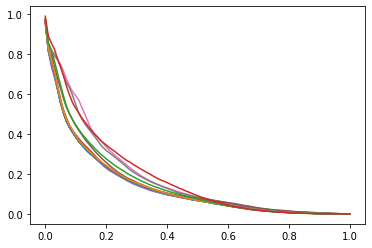

In [187]:
layers = df_adv['layer'].unique()
regularization_weights = df_adv['regularization_weight'].unique()
confidences = df_adv['confidence'].unique()

for l in layers:
    for rw in regularization_weights:
        for c in confidences:
            target_columns = ((df_adv['layer'] == l) 
                              & (df_adv['regularization_weight'] == rw) 
                              & (df_adv['confidence'] == c))
            X_adv = df_adv['threshold'][target_columns].values.reshape(-1, 1)
            y_adv = df_adv['neuron_coverage'][target_columns].values.reshape(-1, 1)
            plt.plot(X_adv, y_adv)
            
plt.show()

# Evaluating Class Averages and Potential Adversarial Bias

NOTE: 

Similarty metrics are argmax'd to get the most similar classes. \
Distance metrics are effectively argmin'd to get the most similar classes. 

In [304]:
from torch.nn.functional import cosine_similarity, pdist
from scipy import spatial
from scipy.stats import wasserstein_distance

In [236]:
data_dir = 'C:\data\MNIST'

if not os.path.exists(data_dir):
    os.makedirs(data_dir)

classes = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
num_classes = len(classes)

dataset = torchvision.datasets.MNIST(root=data_dir, 
                                     train=False, 
                                     download=True,
                                     transform=transforms.Compose([
                                         transforms.ToTensor()
                                     ]))

batch_size = len(dataset)

test_loader = torch.utils.data.DataLoader(dataset,
                                          batch_size=batch_size, 
                                          shuffle=False,
                                          pin_memory=True)

inputs, targets = next(iter(test_loader))

### Get averages for  each class

In [237]:
class_avgs = {}
for i in classes:
    idx = torch.where(targets == i)[0]
    avg_class = np.squeeze(inputs[idx].mean(dim=0))
    class_avgs[i] = avg_class
    # plt.imshow(avg_class)
    # plt.show()

### Cosine Similarity

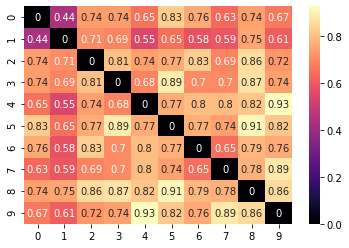

tensor([5, 8, 8, 5, 9, 8, 2, 9, 5, 4])
tensor([0.6200, 0.5564, 0.6854, 0.6828, 0.6737, 0.7158, 0.6638, 0.6466, 0.7373,
        0.6991])
tensor(8)


In [385]:
scores = torch.zeros((num_classes, num_classes))
for i in classes:
    for j in classes:
        if i !=j:
            class_i = class_avgs[i].view(-1)
            class_j = class_avgs[j].view(-1)
            scores[i,j] = cosine_similarity(class_i, class_j, dim=0)

sns.heatmap(scores, annot=True, cmap="magma")
plt.show()

print(scores.argmax(dim=0))
print(scores.mean(dim=1))
print(scores.mean(dim=1).argmax())

### Dot Product Similarity

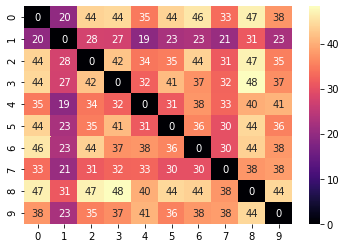

tensor([8, 8, 8, 8, 9, 8, 0, 9, 3, 8])
tensor([35.0466, 21.3951, 34.0822, 34.2245, 30.2852, 32.0299, 33.4776, 28.6871,
        38.3172, 32.9084])
tensor(8)


In [384]:
d_scores = torch.zeros((num_classes, num_classes))
for i in classes:
    for j in classes:
        if i !=j:
            class_i = class_avgs[i].view(-1).numpy()
            class_j = class_avgs[j].view(-1).numpy()
            d_scores[i,j] = np.dot(class_i, class_j).astype(np.float64)

sns.heatmap(d_scores, annot=True, cmap="magma")
plt.show()

print(d_scores.argmax(dim=0))
print(d_scores.mean(dim=1))
print(d_scores.mean(dim=1).argmax())

### P-Norm Distance

p-norm: 0


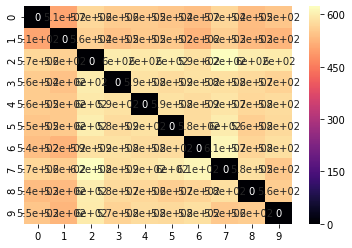

tensor([1, 0, 1, 1, 1, 0, 1, 9, 1, 1])
tensor([493.2000, 486.6000, 534.1000, 517.3000, 519.5000, 518.6000, 515.2000,
        527.0000, 508.8000, 508.5000])
tensor(1) 

p-norm: 1


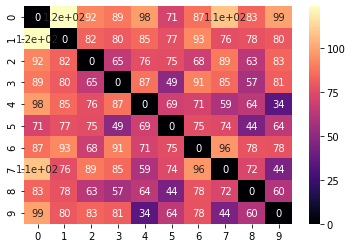

tensor([5, 7, 8, 5, 9, 8, 2, 9, 5, 4])
tensor([85.0862, 77.3947, 69.3543, 68.3582, 64.2277, 59.8132, 73.6159, 70.3551,
        59.9175, 62.4087])
tensor(5) 

p-norm: 2


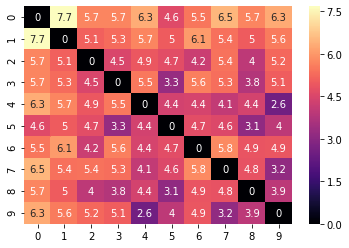

tensor([5, 5, 8, 5, 9, 8, 2, 9, 5, 4])
tensor([5.4064, 5.0843, 4.3812, 4.4116, 4.2340, 3.8356, 4.6086, 4.5085, 3.9693,
        4.0704])
tensor(5) 

p-norm: inf


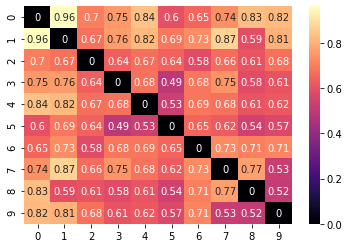

tensor([5, 8, 6, 5, 5, 3, 2, 9, 9, 8])
tensor([0.6888, 0.6910, 0.5857, 0.5947, 0.6136, 0.5346, 0.6132, 0.6341, 0.5753,
        0.5858])
tensor(5) 



In [386]:
p_norms = [0, 1, 2, np.inf]

for p in p_norms:
    
    print('p-norm:', p)
    p_scores = torch.zeros((num_classes, num_classes))
    
    for i in classes:
        for j in classes:
            
            if i !=j:
                class_i = class_avgs[i].view(-1)
                class_j = class_avgs[j].view(-1)
                stacked_classes = torch.stack((class_i, class_j))
                p_scores[i,j] = pdist(stacked_classes, p)

    sns.heatmap(p_scores, annot=True, cmap="magma")
    plt.show()

    print(p_scores.argsort()[:,1:2].view(-1))
    print(p_scores.mean(dim=1))
    print(p_scores.mean(dim=1).argmin(), '\n')

### Wasserstein Distance

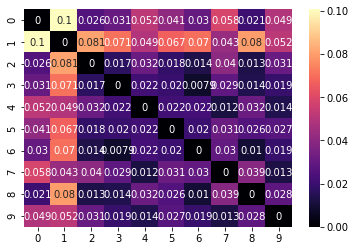

tensor([8, 7, 8, 6, 7, 2, 3, 4, 6, 7])
tensor([0.0408, 0.0614, 0.0272, 0.0230, 0.0256, 0.0272, 0.0223, 0.0295, 0.0262,
        0.0252])
tensor(6)


In [381]:
w_scores = torch.zeros((num_classes, num_classes))
for i in classes:
    for j in classes:
        if i !=j:
            class_i = class_avgs[i].view(-1).numpy()
            class_j = class_avgs[j].view(-1).numpy()
            w_scores[i,j] = wasserstein_distance(class_i, class_j)

sns.heatmap(w_scores, annot=True, cmap="magma")
plt.show()

print(w_scores.argsort()[:,1:2].view(-1))
print(w_scores.mean(dim=1))
print(w_scores.mean(dim=1).argmin())

### Canberra Distance

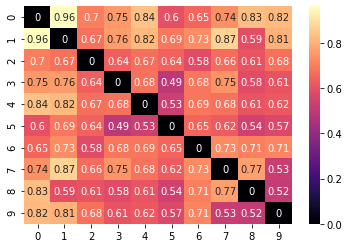

tensor([5, 8, 6, 5, 5, 3, 2, 9, 9, 8])
tensor([0.6888, 0.6910, 0.5857, 0.5947, 0.6136, 0.5346, 0.6132, 0.6341, 0.5753,
        0.5858])
tensor(5)


In [379]:
c_scores = torch.zeros((num_classes, num_classes))
for i in classes:
    for j in classes:
        if i !=j:
            class_i = class_avgs[i].view(-1).numpy()
            class_j = class_avgs[j].view(-1).numpy()
            c_scores[i,j] = spatial.distance.chebyshev(class_i, class_j).astype(np.float64)

sns.heatmap(c_scores, annot=True, cmap="magma")
plt.show()

print(c_scores.argsort()[:,1:2].view(-1))
print(c_scores.mean(dim=1))
print(c_scores.mean(dim=1).argmin())

### Bray Curtis Distance

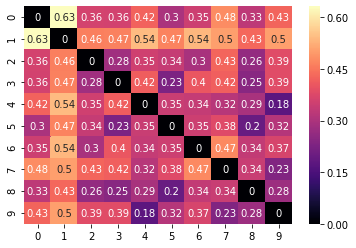

tensor([5, 8, 8, 5, 9, 8, 2, 9, 5, 4])
tensor([0.3660, 0.4550, 0.3177, 0.3203, 0.3210, 0.2923, 0.3452, 0.3585, 0.2714,
        0.3074])
tensor(8)


In [380]:
b_scores = torch.zeros((num_classes, num_classes))
for i in classes:
    for j in classes:
        if i !=j:
            class_i = class_avgs[i].view(-1).numpy()
            class_j = class_avgs[j].view(-1).numpy()
            b_scores[i,j] = spatial.distance.braycurtis(class_i, class_j)

sns.heatmap(b_scores, annot=True, cmap="magma")
plt.show()

print(b_scores.argsort()[:,1:2].view(-1))
print(b_scores.mean(dim=1))
print(b_scores.mean(dim=1).argmin())